
    
## Description 

The following notebook details our approach to predict the generation of revenue through ad display.

  1. We will first start by exploring and understanding the data at hand to extract valuable insight.

  2. We will answer the preliminary questions.

  2. We will experiment with a few classification algorithms and evaluate their performance.

* This notebook was executed in a conda environment. To recreate these results and avoid any version conflict problems, use the following package versions :

    - CatBoost : 0.20
    - scikit-learn : 0.20.3
    - scikit-optimize : 0.5.2

* We only ignore the warnings for format concers. However, they were taken into consideration and only ignored after previous execution.

In [1]:
#To avoid warnings
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
%load_ext autoreload

In [3]:
# In order to get the execution time of each cell
%load_ext autotime

### Importing the required libraries

In [1]:
# For data manipulation
import numpy as np
import pandas as pd
import seaborn as sns             #visualisation
import matplotlib.pyplot as plt   #visualisation
import shap

from scipy.stats import norm
from scipy.stats import kurtosis
from statistics import median 


#Scikit-Learn Functions
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder  
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score, f1_score,
recall_score, classification_report,confusion_matrix, make_scorer)
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#Models
import lightgbm as lgbm
import catboost


# Skopt functions
from skopt import gp_minimize
from skopt import BayesSearchCV
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper


from copy import deepcopy
from time import time
import gc
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [14]:
import os
def find_all(name, path):
    result = []
    for root, dirs, files in os.walk(path):
        if name in files:
            result.append(os.path.join(root, name))
    return result

In [15]:
path= "tmp/documents"
name = "ho"

In [16]:
find_all(name,path)

[]

#   Data exploration

* Let's load the data into a pandas data frame :

In [5]:
df = pd.read_csv('/Users/HAEK/Desktop/aft100k.csv', header = 0)
# To display the top 3 rows 
#df.head(5)  

time: 89.9 ms


* Let's look at the shape of our data :

In [6]:
df.shape

(100000, 6)

time: 8.84 ms


* Let's list our columns and see how well did Pandas infer the data types of our columns :

In [7]:
df.columns

Index(['creative_id', 'user_operating_system', 'user_device',
       'average_seconds_played', 'cost', 'revenue'],
      dtype='object')

time: 2.08 ms


In [8]:
df.dtypes

creative_id                 int64
user_operating_system      object
user_device                object
average_seconds_played    float64
cost                      float64
revenue                   float64
dtype: object

time: 3.56 ms


It looks like pandas has interpreted the column types well.

* Let's generate descriptive statistics that summarize the central tendency, dispersion, and shape of a dataset’s distribution. We will omit the creative_id : 

In [9]:
df.drop('creative_id', axis = 1).describe([.25,.50,.70,.75])

,average_seconds_played,cost,revenue
count,38172.000000,100000.000000,100000.000000
mean,10.601625,0.005671,0.007789
std,9.791514,0.003503,0.014616
min,0.000000,0.000473,0.000000
25%,3.000000,0.003308,0.000000
50%,9.000000,0.004837,0.000000
70%,14.500000,0.006157,0.000000
75%,16.000000,0.006616,0.013416
max,175.000000,0.052878,0.145641


time: 45.6 ms


For the __average_seconds_played__, 38% of the data is not null. The mean number of seconds per user is __10.6 s__.

The mean cost is 0.0056 per display with a standard deviation of 0.0035. 

The revenue has no missing data. The average revenue per display is 0.0077 which is higher than the mean cost. The standard deviation is 0.014, higher than the mean which indicates that the data has high variance. At the 70th percentile the revenue is still 0, which indicates that the most revenue is made by the approx. 30% of the users.  



* Let's explore the values of each column :

In [10]:
df.nunique()

creative_id                936
user_operating_system       12
user_device                  4
average_seconds_played    3196
cost                       134
revenue                    222
dtype: int32

time: 121 ms


* Now that we have the count of unique values, let's look at numerical variables' distribution and scatter plots :

Text(0.5, 1.08, 'Variables pairplot')

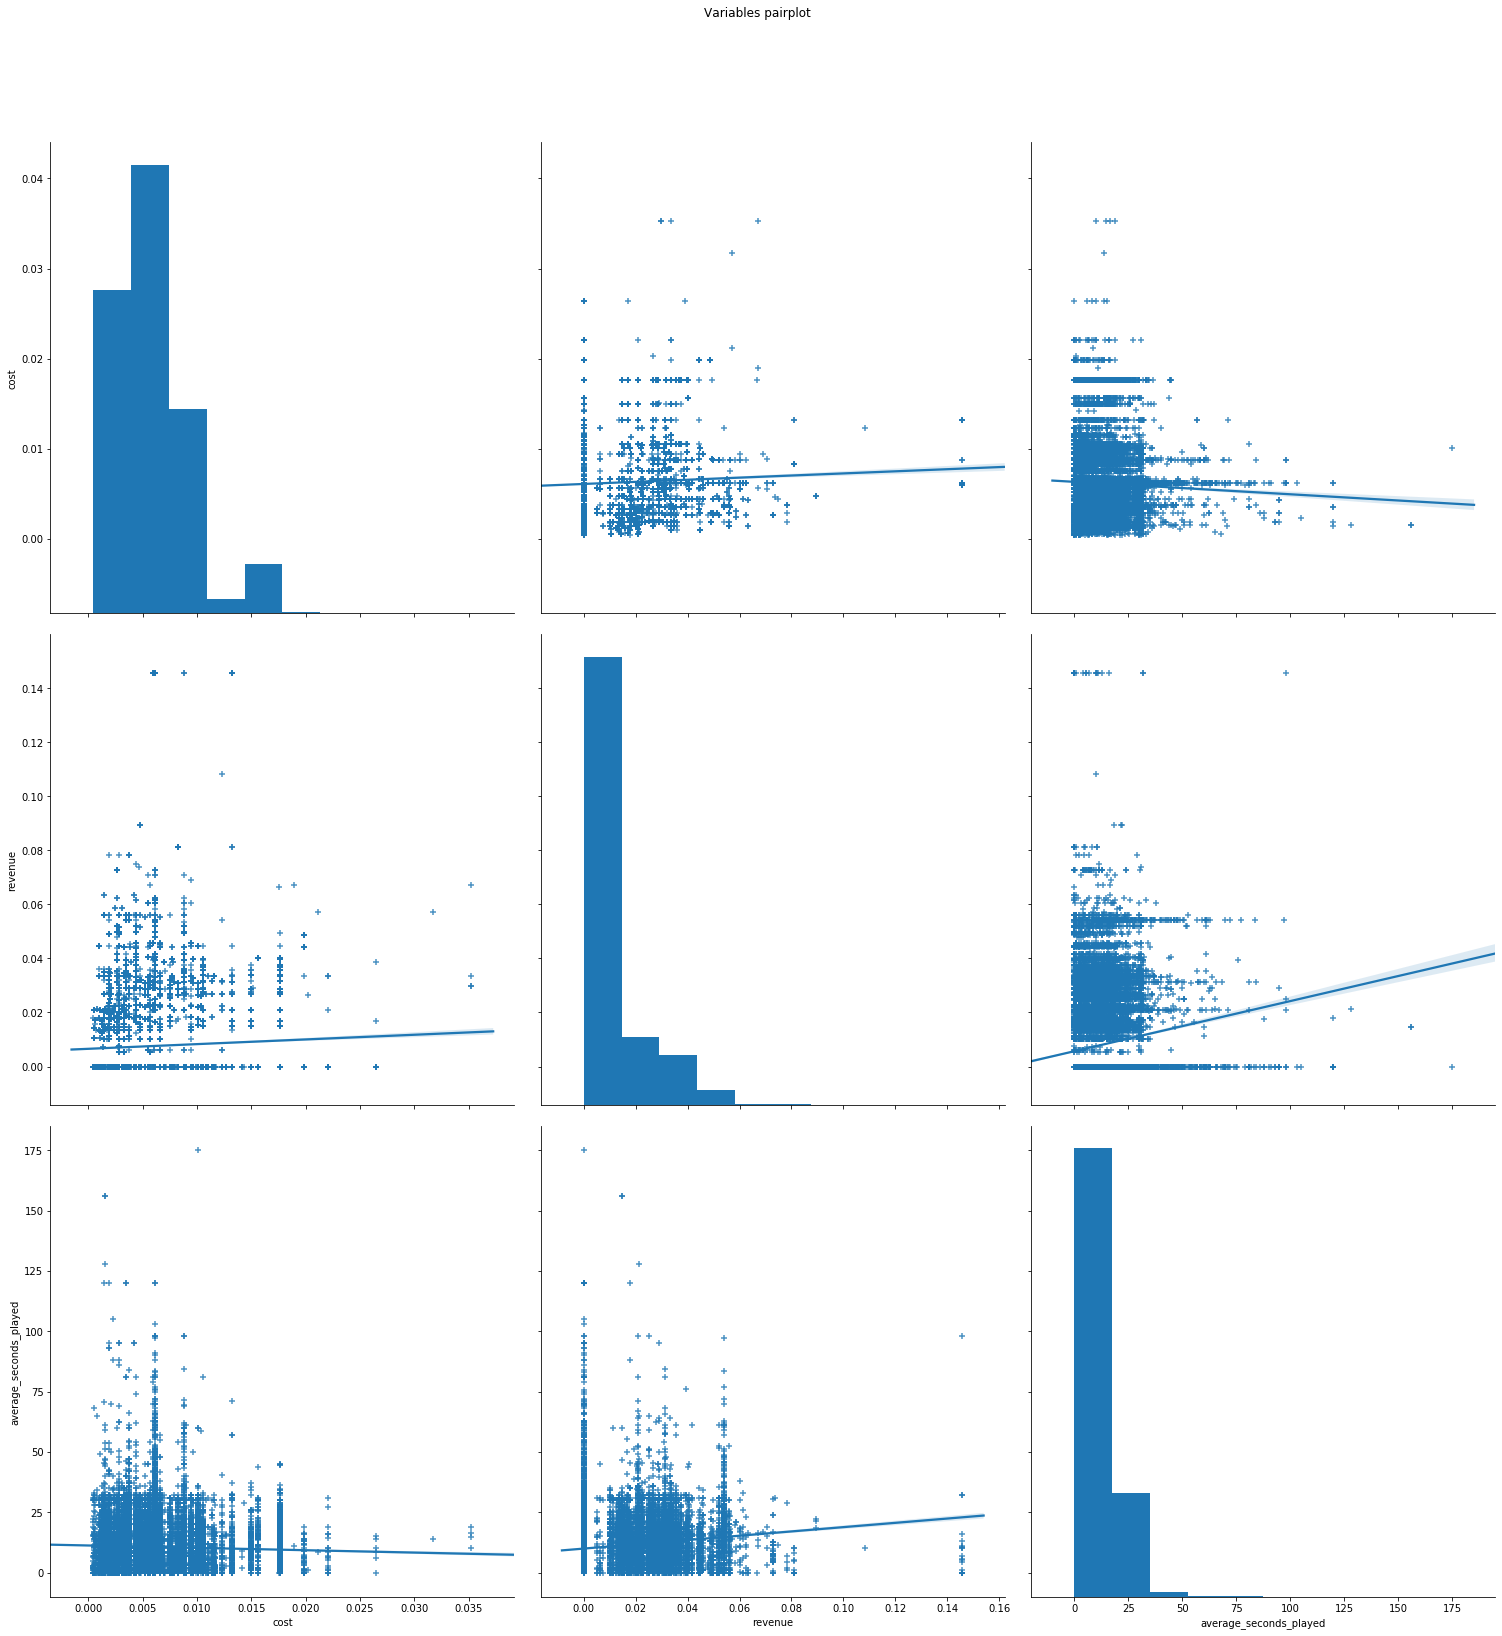

time: 21.2 s


In [11]:
plot = sns.pairplot(df.dropna(), vars = ['cost','revenue','average_seconds_played'],
             kind="reg", markers="+", palette = 'Set2', height = 7)
plot.fig.suptitle("Variables pairplot", y=1.08)

The histograms show that the __revenue__ and the __average_seconds_played__ are heavily right-skewed. 

The scatter plots don't indicate a relevant correlation between the variables.

* Let's check the skewness of the columns : 

In [12]:
# skewness along the index axis 
df.drop('creative_id', axis = 1).skew(axis = 0, skipna = True) 

average_seconds_played    2.089957
cost                      1.591194
revenue                   2.196735
dtype: float64

time: 83.7 ms


The three columns are highly skewed.


* Let's have a look at the correlation between the numerical variables : 

                        average_seconds_played      cost   revenue
average_seconds_played                1.000000 -0.036792  0.128387
cost                                 -0.036792  1.000000  0.022819
revenue                               0.128387  0.022819  1.000000


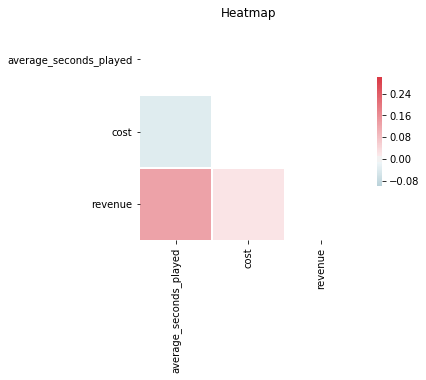

time: 324 ms


In [13]:
# Compute the correlation matrix
corr = df.drop('creative_id', axis=1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.heatmap(corr, cmap=cmap, mask = mask,  vmax=.3, vmin = -.1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_title('Heatmap')
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
print(corr)

The overall correlation coefficients are weak, which means that there is no linear relationship between the variables.

The highest correlation is between the __revenue__ and the __average_seconds_played__ (~13%;  still very low).


* Let's look at  the categorical variables :



*   First, we will take a look at the 50 most displayed videos, and assess the difference between their frequencies.




Text(0.5, 1.0, 'Count for the 50 most frequent videos')

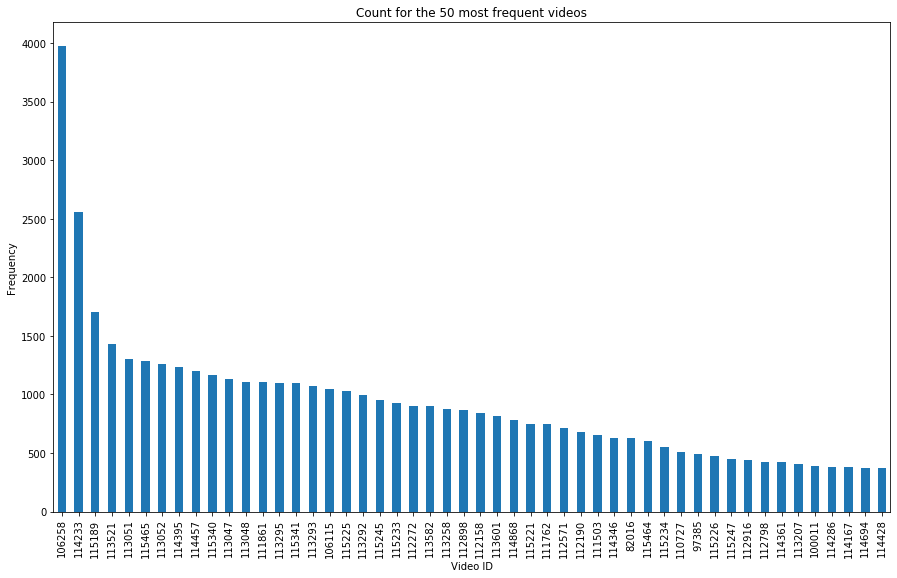

time: 937 ms


In [14]:
# Plot the count for the 50 most frequent videos
ax = df['creative_id'].value_counts().nlargest(50).plot(kind='bar',
                                    figsize=(15,9),
                                    title="Count for each Video")
ax.set_xlabel("Video ID")
ax.set_ylabel("Frequency")
ax.set_title('Count for the 50 most frequent videos')

> * In this dataset, some videos are displayed more than others. The video with the highest frequency was displayed about 4000 times.

* Let's look at device count :

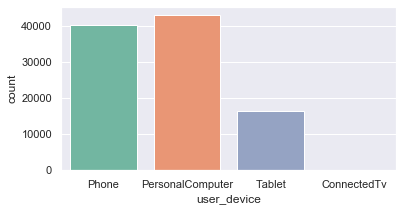

time: 193 ms


In [15]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(6,3)})
sns.countplot(df['user_device'], palette="Set2")

The most frequest devices are personal computers and phones.

* Let's look at the operating systems :

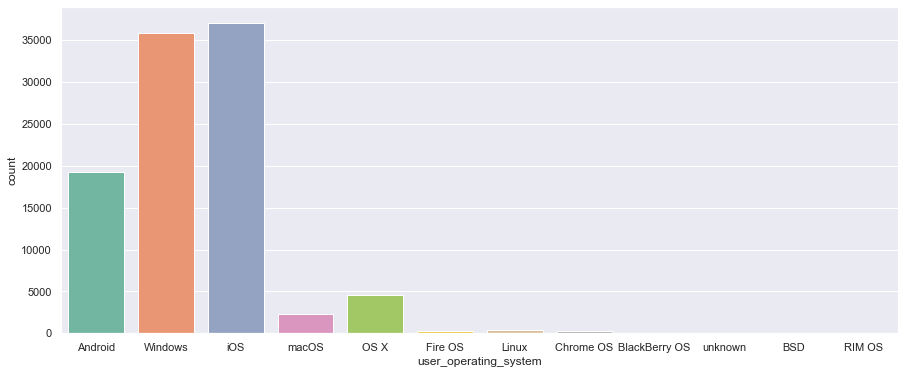

time: 412 ms


In [16]:
sns.set(rc={'figure.figsize':(15,6)})
sns.countplot(df['user_operating_system'], palette="Set2")

 The most used operating systems are iOS and Windows.

* Let's plot the relationship, using boxplots, between the categorical variables (ie **user_device** and **user_operating_system**) and the numerical features (**revenue** and **average_seconds_played**) :

 *We don't plot the __creative_id__ since it has a high cardinality* 

* First, the average_seconds_played :

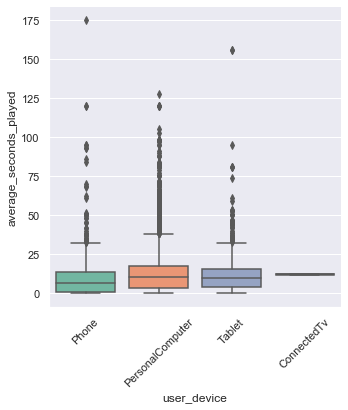

time: 526 ms


In [17]:
a = sns.catplot(x="user_device", y="average_seconds_played", 
                data=df, height=5, aspect=1, palette="Set2", kind="box")
a.set_xticklabels(rotation=45)

The plot show that users on personal computers and tablets tend to watch the videos longer than phone users.

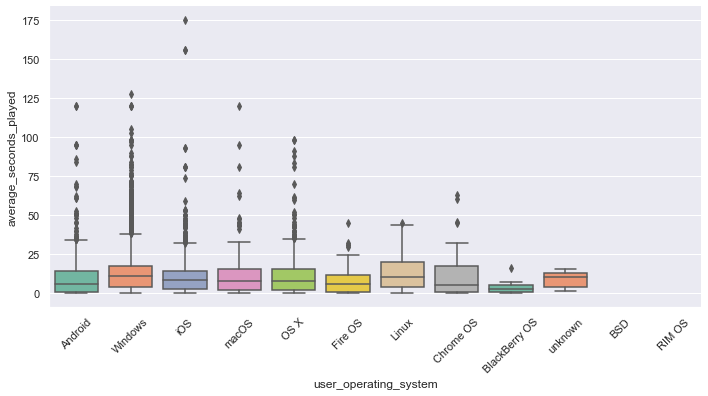

time: 883 ms


In [18]:
b = sns.catplot(x="user_operating_system", y="average_seconds_played", 
                data=df, height=5, aspect=2, palette="Set2", kind="box")
b.set_xticklabels(rotation=45)

The plot shows that Windows and Linux users tend to watch the videos the longest. However, we keep in mind that the data we have on Linux users is very little. Most operating systems have outliers. The highest averages recorded are for iOS users.  

* Then, the revenue :

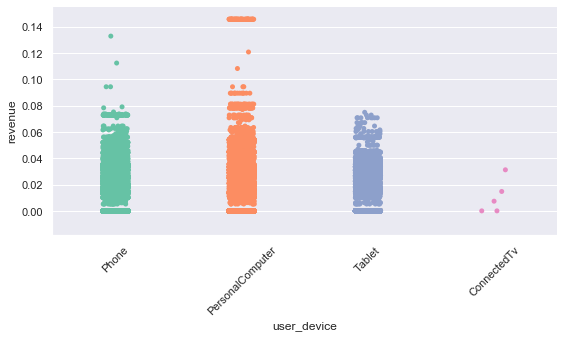

time: 2.01 s


In [19]:
a = sns.catplot(x="user_device", y="revenue", 
                data=df, height=4, aspect=2, palette="Set2")
a.set_xticklabels(rotation=45)

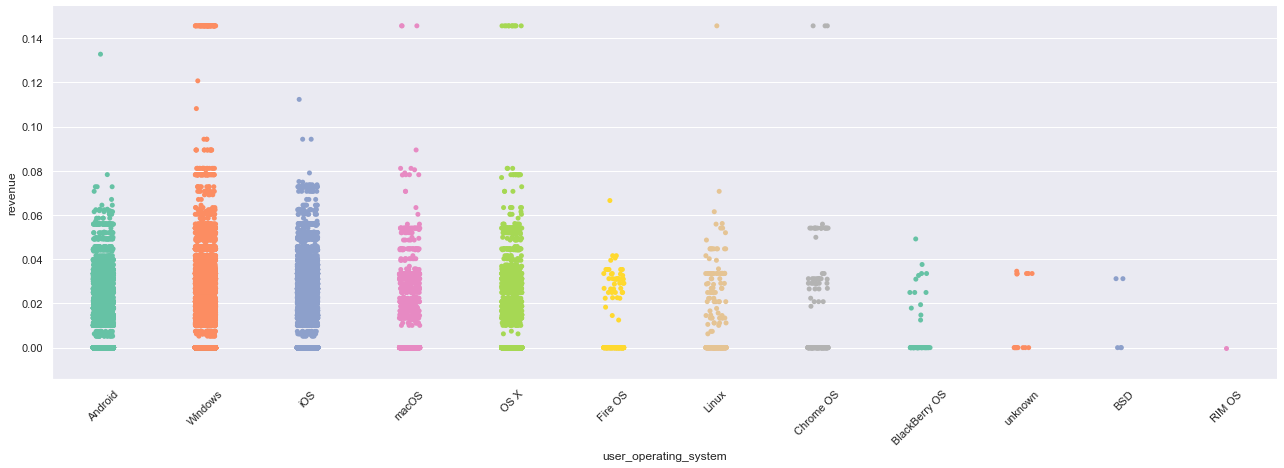

time: 2.25 s


In [20]:
b = sns.catplot(x="user_operating_system", y="revenue", 
                data=df, height=6, aspect=3, palette="Set2")
b.set_xticklabels(rotation=45)

It looks like personal computers and phones generate the most revenue.


It seems the iOS and Windows generate the most revenue.

The displays with the maximum revenue values are watched mostly on computers, which makes sense since the screens are bigger, and the user is far more likely to leave the ad within the frame, as supposed to when the user is on his phone (which is what I personnaly do :)).

* Let's check if our dataset has any null values :

In [21]:
df.isnull().values.any()

True

time: 10.4 ms


* Since we have null values, let's check how many we have for each column :

In [22]:
df.isnull().sum()

creative_id                   0
user_operating_system         0
user_device                   8
average_seconds_played    61828
cost                          0
revenue                       0
dtype: int64

time: 16.6 ms


About 62% of the values for the __average_seconds_played__ are missing, and 8 values are missing from the __user_device__ column.

#  Preliminary questions 

## Question 1: The margin being defined as (revenue - cost) / revenue, what is our global margin based on this log?

The global margin can be calculated by summing the revenue and the cost for all the displays.

* Let's add a column to the dataframe indicating profit, where profit = revenue - cost :

In [23]:
df['profit'] = df['revenue'] - df['cost']

time: 2.07 ms


In [24]:
df['profit'].describe([.25,.50,.70,.75])

count    100000.000000
mean          0.002118
std           0.014952
min          -0.052878
25%          -0.006157
50%          -0.003781
70%          -0.001418
75%           0.008172
max           0.139704
Name: profit, dtype: float64

time: 9.39 ms


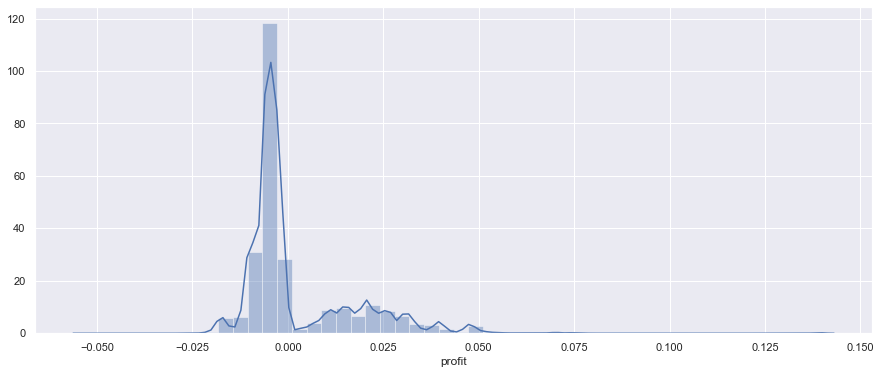

time: 521 ms


In [25]:
sns.distplot(df['profit'])

We can tell from the profit column that there is a loss up until about the 75th percentile.

* Let's add a margin column. Since we have many null revenues, we made the business choice to consider the margin for null revenues as zero   :

In [26]:
df['margin'] = df['profit']/df['revenue']
# Replace the -inf margin with 0
df['margin'][df['margin'] == -np.inf] = 0
df['margin'].describe([.25,.50,.70,.75])

count    100000.000000
mean          0.210808
std           0.356887
min          -0.968617
25%           0.000000
50%           0.000000
70%           0.000000
75%           0.542469
max           0.983091
Name: margin, dtype: float64

time: 19.6 ms


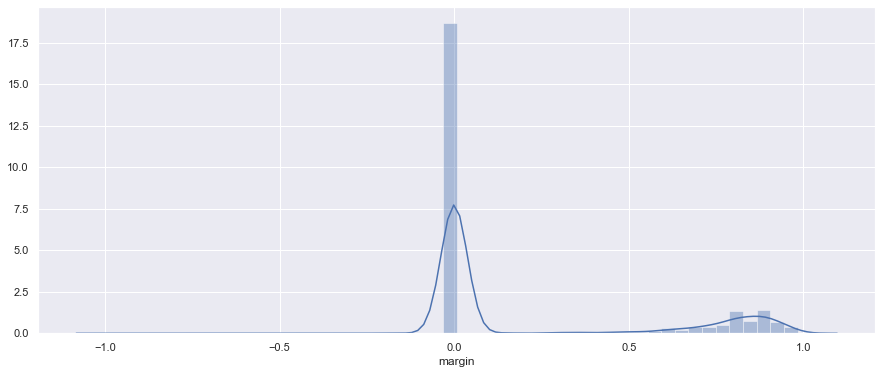

time: 551 ms


In [27]:
sns.distplot(df['margin']);

As seen with the profit, a positive margin is only seen starting from ~70th percentile. The maximum margin for a display is 98% and the minimum is 96%.

* Let's compute the global margin using the sum of profits and revenues : 

In [28]:
print("The global margin : " , sum(df['profit'])/sum(df['revenue']))

The global margin :  0.2719071413410909
time: 20.7 ms


__Answer__ :  The global margin accumulates to __27%__.

## Question 2: Can you think of other interesting metrics to optimize?

**Answer**: $\frac{\text{How many times a video generated revenue}}{\text{ How many times the video was displayed}}$

* It would be interesting to look at **How many times a video generated revenue/How many times the video was displayed**, and try to maximize this fraction. 

* Since the users have a limited attention span, it would be interesting to look at the **revenue per seconds played** and try to maximize it. But this depends on how the revenue is generated.


##  Question 3: What are the most profitable Operating Systems?

* Let's group the operating systems by profit : 

In [29]:
os_profit = df.groupby(['user_operating_system'])[['profit']].sum()
os_profit = os_profit.sort_values(by = 'profit' ,ascending = False)
os_profit.reset_index(inplace = True)
os_profit

,user_operating_system,profit
0,iOS,115.521775
1,Windows,65.873808
2,Android,27.279364
3,OS X,1.707775
4,Chrome OS,0.428130
5,Linux,0.372922
6,macOS,0.248021
7,Fire OS,0.142575
8,unknown,0.093995
9,BlackBerry OS,0.077391


time: 19.1 ms


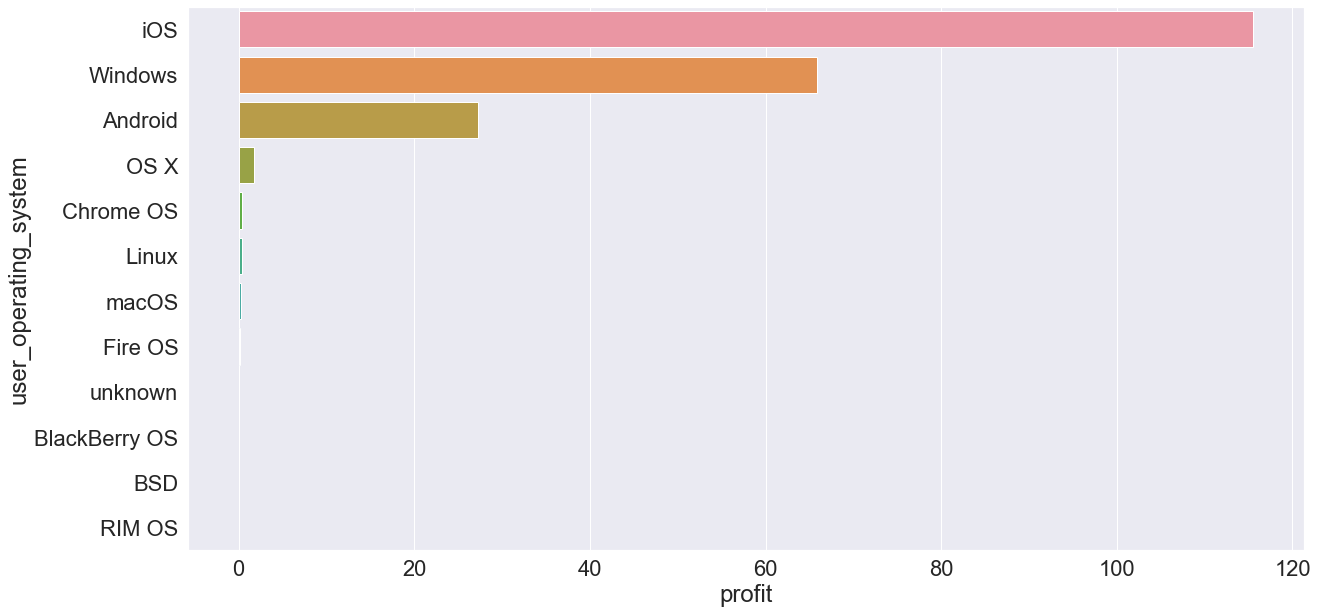

time: 716 ms


In [30]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
sns.barplot(y="user_operating_system", x = "profit" ,data = os_profit)

__Answer__ : The most profitable operating systems are by far __iOS__ followed by __Windows__ and __Android__.

## For fun :)

### The most profitable devices 

In [31]:
device_profit = df.groupby(['user_device'])[['profit']].sum()
device_profit = device_profit.sort_values(by = 'profit' ,ascending = False)
device_profit.reset_index(inplace= True)
device_profit

,user_device,profit
0,Phone,73.300949
1,Tablet,69.683578
2,PersonalComputer,68.700882
3,ConnectedTv,0.042905


time: 17.1 ms


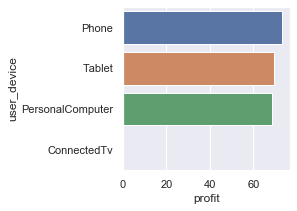

time: 313 ms


In [32]:
sns.set(font_scale= 1)
plt.figure(figsize=(3, 3))
sns.barplot(y="user_device", x = "profit", data = device_profit)

The most profitable devices are phones, tablets followed by personal computers.

#  Machine Learning

Our objective is to use the data to predict the event of __*making a revenue*__. Thereby, it is a **classification** problem, a binary classification problem to be exact.

##  Data Preparation

Before building models to predict the target, we will start by preparing the data first.  We will tackle :

1. The missing data
2. Scaling and normalization
3. Building the target
4. Categorical data

### Missing Data

* Let's start by adressing the __missing data__.



* As seen in the data exploration segment, two columns have missing values : **user_device** has 8 missing values, and **average\_seconds\_played** has 62K Nan values which accounts for 62% of the data.


* Since **user_device** does not have that many missing values, we will drop the 8 rows.

In [33]:
df.dropna(axis=0, subset=['user_device'], inplace = True)
df.shape

(99992, 8)

time: 17.7 ms


* Since more than half of the data is missing for the **average_seconds_played**, we cannot drop those rows.

* The data is MAR (Missing At Random), meaning that it is due to observed data.

* To deal with the missing values, we consider two approaches :
 1. We replace the NaN values with the median. Since we have 38K observed user behaviours, we can generalize it for new unknown users by using the mean of our observations, meaning that we safely approximate the average_seconds_played for new users by the mean of average_seconds_played in our identified set. Moreover, since our dataset has a lot of outliers, we choose the median over the mean.

 2. We replace the NaN values with a constant outside fixed value range.

    For both these approaches, we add a new indicator feature that encodes when a value is missing.

* For simplicity reasons, we will create two columns, for each of these approaches to fill the missing values :

In [34]:
# The indicator column
# 1 : the data is missing, 0 : the data is not missing
df['average_seconds_played_isnull'] = np.where(df['average_seconds_played'].isnull(), 1, 0)
#Check the values' count
df['average_seconds_played_isnull'].value_counts()

1    61820
0    38172
Name: average_seconds_played_isnull, dtype: int64

time: 6.4 ms


In [35]:
# Column filled with constant (-1)
df['average_seconds_played_constant'] = df['average_seconds_played'].fillna(-1)
#Column filled with median
df['average_seconds_played_median'] = df['average_seconds_played'].fillna(df['average_seconds_played'].median())

time: 7.95 ms


### Scaling and normalization

* Since we intend to use tree based models, there is no need to scale our data.

### Building the target

* The goal behind this study is to predict the event 'we benefit from a revenue' (ie revenue > 0). Therefore, we will classify our dataset into two groups, based on the following rule :

        * 1 : if the display generates revenue (revenue > 0)
        * 0 : if not (revenue = 0)

In [36]:
# Create the target column
df['target'] = np.where(df['revenue']>0, 1, 0)

time: 2.93 ms


In [37]:
df['target'].value_counts()

0    72951
1    27041
Name: target, dtype: int64

time: 10.3 ms


This is an imbalanced dataset and the ratio Class-0 to Class-1 instances is 73:27 or about 3:1.
We're going to have to keep that in mind whilst building our train/test datasets.

### Categorical Data

* There are numerous ways to handle categorical data.


* In our case, two of the models we will use handle categorical data without needing any encoding, however random forest does not.


* We chose **Label Encoding** over One-Hot-Encoding due to the high cardinality of the creative_id which would leave us with 950 features if we use OHE. Another reason, is a bug with a hyper-parameter optimization function which does not accept variables with type : string.

In [38]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

time: 3.64 ms


In [39]:
df = MultiColumnLabelEncoder(columns = ['creative_id','user_operating_system', 'user_device' ]).fit_transform(df)

time: 68.6 ms


### Splitting the dataset to train and test datasets

* Let's choose the features to feed our models :


* As input data we will use : creative_id, user_operating_system, user_device,average_seconds_played_median, cost, and average_seconds_played_isnull.


* As for the creative_id, it seems that the nature of the video influences the revenue. However, we do keep in mind that for new datasets we might have new videos, where cold start might be an issue.


In [40]:
predictors = df[['creative_id','user_operating_system','user_device',
                 'average_seconds_played_constant','cost','average_seconds_played_isnull']]
target = df['target']

time: 13.3 ms


* Let's split the data into a training set and a test set. Since our data is imbalanced, we use the stratify option to divide the data into homogeneous sets .


* We use 75% of the data to train our models, and the remaining 25% to test their performance :


In [41]:
train_ratio = 0.75
X_train, X_test, y_train, y_test = train_test_split(predictors,target, stratify=target,test_size=1 - train_ratio,
                                                     random_state=42)
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (74994, 6)
Training Labels Shape: (74994,)
Testing Features Shape: (24998, 6)
Testing Labels Shape: (24998,)
time: 60.4 ms


In [42]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.591111
         Iterations 6
                                  Results: Logit
Model:                    Logit                  Pseudo R-squared:       -0.013    
Dependent Variable:       target                 AIC:                    88671.5610
Date:                     2019-12-10 22:39       BIC:                    88726.9119
No. Observations:         74994                  Log-Likelihood:         -44330.   
Df Model:                 5                      LL-Null:                -43773.   
Df Residuals:             74988                  LLR p-value:            1.0000    
Converged:                1.0000                 Scale:                  1.0000    
No. Iterations:           6.0000                                                   
-----------------------------------------------------------------------------------
                                 Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
---------

In [50]:
logreg.

TypeError: 'NoneType' object is not callable

time: 9.57 ms


In [43]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

time: 240 ms


In [46]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[18200,    38],
       [ 6743,    17]])

time: 21.4 ms


In [45]:
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))
print ("ROC_AUC:" , roc_auc_score(y_test, y_pred))
print ("Accuracy:" , accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84     18238
           1       0.31      0.00      0.00      6760

   micro avg       0.73      0.73      0.73     24998
   macro avg       0.52      0.50      0.42     24998
weighted avg       0.62      0.73      0.62     24998

ROC_AUC: 0.500215615552676
Accuracy: 0.7287382990639251
time: 32.9 ms


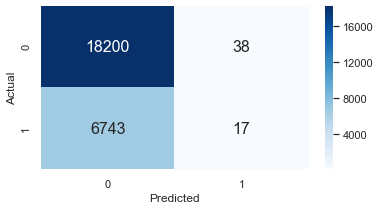

time: 217 ms


In [47]:
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,3))
sns.set(font_scale=1)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size

## Modeling

 **Let's get this party started!**

* We will start by choosing the metrics that will help us evaluate the models.

### Metrics

 * The very simple metric to measure classification is **accuracy** i.e. ratio of correct predictions to the total number of samples in a dataset. However, in our case we have an imbalaced dataset (only 27% for the positive class). Thus, the accuracy can be misguiding as it won't show the prediciton capacity for the minority class. 


* To gain more insight into the model peroformance, in addition to the **accuracy**, we will also use the following metrics :
   - **Precision** : our mistakes into classifying a display as 'revenue generating' if it’s not true.
   - **Recall** : how well our model can predict all 'revenue generating' displays in our dataset.
   - **F1 Score** : harmonic average of the precision and recall.
   - **ROC_AUC** : how much our model is capable of distinguishing between 'revenue generating" displays and their counterpart. 

* In this section we will explore three algorithms : 

    - **_Random Forest_**
    - **_Light GBM_**
    - **_CatBoost_**
    
  
 * We tested Naive Bayes as a baseline model. The model had an accuracy of 72% and a ROC-AUC of 50%. The recall, precison and f1 score were very low. However, we realised that the data is mixed, with both categorical and numerical features, which comprimised the intergrity of the model.
 
 
 * We also tested XGBoost with Grid Search, but it was taking a lot of time to find the best estimator. Consequently, we did not include it in this notebook.


### Random Forest

* To kick start our modeling process, we will establish our baseline model : Random Forest.


* The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree.


* Let's create a Random Forest Classifier :

In [42]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

time: 711 µs


* Let's train our model using the training set :

In [43]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

time: 52 s


* Let's predict the target for the test set :

In [44]:
y_pred = rf.predict(X_test)

time: 6.08 s


* Let's take a look at the classification report : 

In [45]:
print(classification_report(y_test, y_pred))
print ("ROC_AUC:" , roc_auc_score(y_test, y_pred))
print ("Accuracy:" , accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82     18238
           1       0.44      0.21      0.28      6760

   micro avg       0.71      0.71      0.71     24998
   macro avg       0.60      0.55      0.55     24998
weighted avg       0.67      0.71      0.68     24998

ROC_AUC: 0.5549444280781851
Accuracy: 0.7130970477638211
time: 33.3 ms


The model has an accuracy of **71%** and a ROC-AUC of **55%**. However, the recall, the precison and the f1 score are low. 

* Let's plot the feature importances :

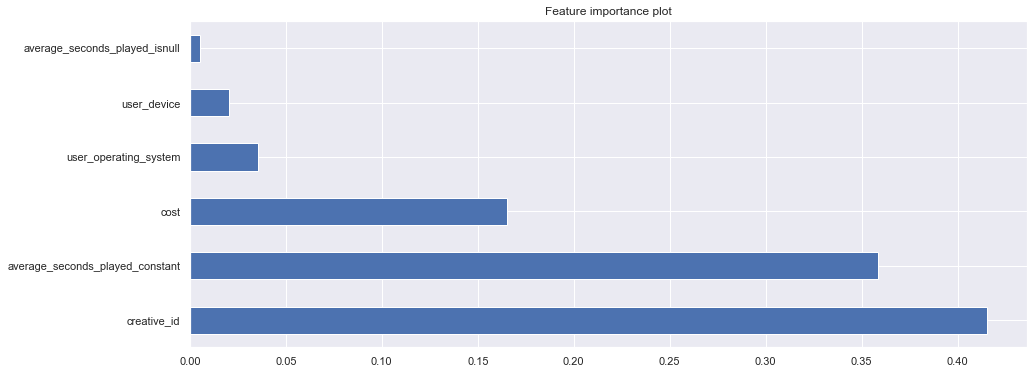

time: 698 ms


In [46]:
(pd.Series(rf.feature_importances_, index=X_train.columns)
   .nlargest(9)
   .plot(kind='barh', title='Feature importance plot')) 

The most important features in this model, by order, are the creative_id, the average_seconds_played and the cost.

The remaining categorical features have low impact.

Our choice of label encoding maybe responsible for the creative_id taking first place.

* The obtained performance maybe due to the imbalanced classes. To try and mend the imbalanced dataset, we will use two cross validation approaches K-Fold cross validation and K-fold stratified cross validation : 

In [47]:
metric_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
scores_df = pd.DataFrame(index=metric_names, columns=['Random-CV', 'Stratified-CV']) # to store the scores
cv = KFold(n_splits=10)
scv = StratifiedKFold(n_splits=10)
clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
for metric in metric_names:
    score1 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=cv).mean()
    score2 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=scv).mean()
    scores_df.loc[metric] = [score1, score2]

time: 8min 9s


In [48]:
scores_df

,Random-CV,Stratified-CV
accuracy,0.712404,0.712297
precision,0.433772,0.433642
recall,0.207553,0.208027
f1,0.280705,0.281114
roc_auc,0.631679,0.631393


time: 4.55 ms


Unfortunatly, the cross validation has not significantly improved the performance. 

We will now move on to different tree based models, more specifically LightGBM and CatBoost. 

### LightGBM

* **Light GBM** is a gradient boosting framework that uses tree based learning algorithm.


* Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise.


* We chose LightGBM because of its high speed, because it can handle large datasets and it takes lower memory to run. It also focuses on accuracy of results.


* For hyperparameter tuning, we chose a **Bayesian hyperparameter Optimization** approach which builds a probability model of the objective function and uses it to select the most promising hyperparameters to evaluate in the true objective function. Here we use gaussian process-based optimisation.


* Let's start by splitting the train set into a train set and a validation set. We don't use the test set in the hyper-parameter optimization to avoid any leak :

!!!!!!! The one-sentence summary of Bayesian hyperparameter optimization is: build a probability model of the objective function and use it to select the most promising hyperparameters to evaluate in the true objective function.

In [49]:
val_ratio = 0.25
X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(X_train,y_train, stratify=y_train, test_size= val_ratio, random_state=42)
X_train_opt.shape,X_val_opt.shape,y_train_opt.shape,y_val_opt.shape

((56245, 6), (18749, 6), (56245,), (18749,))

time: 35 ms


* Let's define the bounds of the dimensions of the search space we want to explore with the hyper-parameter optimization :

In [50]:
space  = [Integer(3, 50, name='max_depth'),
          Integer(6, 100, name='num_leaves'),
          Integer(50, 200, name='min_child_samples'),
          Real(1, 4,  name='scale_pos_weight'),
          Real(0.1,0.9 , name='subsample'),
          Real(0.1, 0.9, name='colsample_bytree'),
          Real(0.0001, 1, name="learning_rate")
         ]

time: 4.63 ms


Lightgbm can handle categorical data even when it is not encoded. However, we did label encode our categorical features because, for some reason we don't know, the optimization function does not accept features with type *string*. Consequently, we encoded our categorical features into integers (Data preperation : Categorical data section) and we used their columns indices to the algorithm that they are categorical even though they're integers. 


* Let's create a list of indices for the categorical data so we can feed it to the model :

In [51]:
categorical_columns = ['creative_id',
                       'user_operating_system',
                       'user_device']
cat_features = [df.columns.get_loc(c) for c in categorical_columns]

time: 703 µs


* Let's define the objective function we want to minimize.

* In this case, we chose the **ROC_AUC** as a metric to maximize. Hence, we will try to minimize **-ROC_AUC** .

In [52]:
def objective(parameters):
    
    # Model parameters 
    params = {'max_depth': parameters[0], #maximum depth of tree
              'num_leaves': parameters[1], #number of leaves in full tree 
              'min_child_samples': parameters[2], #Minimum number of data needed in a child (leaf).
              'scale_pos_weight': parameters[3], #for classes imbalance
              'subsample': parameters[4], #Subsample ratio of the training instance.
              'colsample_bytree': parameters[5], #Subsample ratio of columns when constructing each tree.
              'learning_rate':parameters[6], #impact of each tree on the final outcome
              'metric':'binary_logloss', #loss for binary classification
              'nthread': 8,
              'boosting_type': 'gbdt', #traditional Gradient Boosting Decision Tree
              'objective': 'binary', #for binary classification
              'max_bin': 100,
              'min_child_weight': 0,
              'min_split_gain': 0,
              'subsample_freq': 1,
               }
    

    print('\nNext set of params.....',params)
    
    
    early_stopping_rounds = 50 #reduce excessive iterations
    num_boost_round       = 1000
    
   #Create LightGBM datasets for training and validation
    xgtrain = lgbm.Dataset(X_train_opt.values, label=y_train_opt, 
                           categorical_feature = cat_features) #Indicate the categorical feature indices
    xgvalid = lgbm.Dataset(X_val_opt.values, label=y_val_opt,
                            categorical_feature = cat_features)
    
    evals_results = {}
    
    # Fit model on feature_set and calculate validation AUROC
    model_lgb     = lgbm.train(params,xgtrain,valid_sets=[xgtrain, xgvalid], 
                               valid_names=['train','valid'], 
                               evals_result=evals_results, 
                               num_boost_round=num_boost_round,
                               early_stopping_rounds=early_stopping_rounds,
                               verbose_eval=None, feval=None)
    
    auc = -roc_auc_score(y_val_opt, model_lgb.predict(X_val_opt).round()) #negative AUC since we want to minimize the function
    recall = recall_score(y_val_opt, model_lgb.predict(X_val_opt).round())
    precision = precision_score(y_val_opt, model_lgb.predict(X_val_opt).round())
    accuracy = accuracy_score(y_val_opt, model_lgb.predict(X_val_opt).round())
    f1 = f1_score(y_val_opt, model_lgb.predict(X_val_opt).round())
    
    print('\nAUC.....',-auc,".....iter.....", model_lgb.current_iteration())
    print('\nRecall.....',recall,".....iter.....", model_lgb.current_iteration())
    print('\nPrecision.....',precision,".....iter.....", model_lgb.current_iteration())
    print('\nAccuracy.....',accuracy,".....iter.....", model_lgb.current_iteration())
    print('\nF1 score.....',f1,".....iter.....", model_lgb.current_iteration())
    
    
    gc.collect()
    
    return  auc


time: 3.47 ms


* We are now ready to optimize !

In [53]:
# Gaussian process-based optimisation
best_output = gp_minimize(objective, space, n_calls=100,
                     random_state=0,n_random_starts=10)

"Best score=%.4f" % best_output.fun


Next set of params..... {'max_depth': 31, 'num_leaves': 85, 'min_child_samples': 179, 'scale_pos_weight': 3.541755216352377, 'subsample': 0.598850957428778, 'colsample_bytree': 0.40750536583415997, 'learning_rate': 0.2976048530838179, 'metric': 'binary_logloss', 'nthread': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'max_bin': 100, 'min_child_weight': 0, 'min_split_gain': 0, 'subsample_freq': 1}

AUC..... 0.5 .....iter..... 1

Recall..... 0.0 .....iter..... 1

Precision..... 0.0 .....iter..... 1

Accuracy..... 0.7295855778974879 .....iter..... 1

F1 score..... 0.0 .....iter..... 1

Next set of params..... {'max_depth': 6, 'num_leaves': 32, 'min_child_samples': 122, 'scale_pos_weight': 3.43650618632648, 'subsample': 0.48398173790004595, 'colsample_bytree': 0.4142278368806639, 'learning_rate': 0.836095155661024, 'metric': 'binary_logloss', 'nthread': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'max_bin': 100, 'min_child_weight': 0, 'min_split_gain': 0, 'subsample_freq': 1}


Next set of params..... {'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 200, 'scale_pos_weight': 3.6481405219195118, 'subsample': 0.1752455734653617, 'colsample_bytree': 0.1, 'learning_rate': 1.0, 'metric': 'binary_logloss', 'nthread': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'max_bin': 100, 'min_child_weight': 0, 'min_split_gain': 0, 'subsample_freq': 1}

AUC..... 0.5963828428465408 .....iter..... 55

Recall..... 0.755818540433925 .....iter..... 55

Precision..... 0.332235130917288 .....iter..... 55

Accuracy..... 0.5231745693103632 .....iter..... 55

F1 score..... 0.4615755239701277 .....iter..... 55

Next set of params..... {'max_depth': 50, 'num_leaves': 100, 'min_child_samples': 200, 'scale_pos_weight': 2.0783738168384724, 'subsample': 0.4240587773440413, 'colsample_bytree': 0.6668834988550605, 'learning_rate': 0.783693608471119, 'metric': 'binary_logloss', 'nthread': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'max_bin': 100, 'min_child_weight': 0, 'min_


AUC..... 0.5 .....iter..... 1000

Recall..... 0.0 .....iter..... 1000

Precision..... 0.0 .....iter..... 1000

Accuracy..... 0.7295855778974879 .....iter..... 1000

F1 score..... 0.0 .....iter..... 1000

Next set of params..... {'max_depth': 50, 'num_leaves': 100, 'min_child_samples': 200, 'scale_pos_weight': 1.0, 'subsample': 0.9, 'colsample_bytree': 0.1010425801524989, 'learning_rate': 0.456591864038718, 'metric': 'binary_logloss', 'nthread': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'max_bin': 100, 'min_child_weight': 0, 'min_split_gain': 0, 'subsample_freq': 1}

AUC..... 0.5443753169495043 .....iter..... 29

Recall..... 0.1280078895463511 .....iter..... 29

Precision..... 0.5472175379426644 .....iter..... 29

Accuracy..... 0.7355592298255907 .....iter..... 29

F1 score..... 0.20748081841432223 .....iter..... 29

Next set of params..... {'max_depth': 3, 'num_leaves': 6, 'min_child_samples': 200, 'scale_pos_weight': 3.102906118873917, 'subsample': 0.9, 'colsample_bytree': 0


Next set of params..... {'max_depth': 46, 'num_leaves': 6, 'min_child_samples': 200, 'scale_pos_weight': 3.1995253721506494, 'subsample': 0.9, 'colsample_bytree': 0.2735098687166946, 'learning_rate': 0.8306925244389189, 'metric': 'binary_logloss', 'nthread': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'max_bin': 100, 'min_child_weight': 0, 'min_split_gain': 0, 'subsample_freq': 1}

AUC..... 0.617002321328436 .....iter..... 129

Recall..... 0.7250493096646943 .....iter..... 129

Precision..... 0.35369960550370444 .....iter..... 129

Accuracy..... 0.5673902608139101 .....iter..... 129

F1 score..... 0.47545754381426636 .....iter..... 129

Next set of params..... {'max_depth': 3, 'num_leaves': 6, 'min_child_samples': 200, 'scale_pos_weight': 1.0, 'subsample': 0.9, 'colsample_bytree': 0.9, 'learning_rate': 0.746894251731054, 'metric': 'binary_logloss', 'nthread': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'max_bin': 100, 'min_child_weight': 0, 'min_split_gain': 0, 'subsampl


Next set of params..... {'max_depth': 40, 'num_leaves': 22, 'min_child_samples': 122, 'scale_pos_weight': 1.0272624007370637, 'subsample': 0.1279146850294747, 'colsample_bytree': 0.4680234338179825, 'learning_rate': 0.27738153963781753, 'metric': 'binary_logloss', 'nthread': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'max_bin': 100, 'min_child_weight': 0, 'min_split_gain': 0, 'subsample_freq': 1}

AUC..... 0.5373684637027661 .....iter..... 113

Recall..... 0.11735700197238659 .....iter..... 113

Precision..... 0.5050933786078099 .....iter..... 113

Accuracy..... 0.7302256120326417 .....iter..... 113

F1 score..... 0.19046094750320103 .....iter..... 113

Next set of params..... {'max_depth': 50, 'num_leaves': 6, 'min_child_samples': 200, 'scale_pos_weight': 2.894789367844965, 'subsample': 0.9, 'colsample_bytree': 0.9, 'learning_rate': 0.8022661087218697, 'metric': 'binary_logloss', 'nthread': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'max_bin': 100, 'min_child_weight':


Next set of params..... {'max_depth': 17, 'num_leaves': 92, 'min_child_samples': 198, 'scale_pos_weight': 3.6747148620169146, 'subsample': 0.10649286248274202, 'colsample_bytree': 0.6019762141613622, 'learning_rate': 0.0002040639395288822, 'metric': 'binary_logloss', 'nthread': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'max_bin': 100, 'min_child_weight': 0, 'min_split_gain': 0, 'subsample_freq': 1}

AUC..... 0.5 .....iter..... 510

Recall..... 0.0 .....iter..... 510

Precision..... 0.0 .....iter..... 510

Accuracy..... 0.7295855778974879 .....iter..... 510

F1 score..... 0.0 .....iter..... 510

Next set of params..... {'max_depth': 50, 'num_leaves': 6, 'min_child_samples': 50, 'scale_pos_weight': 2.7584011018673107, 'subsample': 0.9, 'colsample_bytree': 0.1, 'learning_rate': 0.9568230083547282, 'metric': 'binary_logloss', 'nthread': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'max_bin': 100, 'min_child_weight': 0, 'min_split_gain': 0, 'subsample_freq': 1}

AUC..... 0.6


Next set of params..... {'max_depth': 31, 'num_leaves': 6, 'min_child_samples': 200, 'scale_pos_weight': 2.9941237672055325, 'subsample': 0.9, 'colsample_bytree': 0.1, 'learning_rate': 0.822731059922438, 'metric': 'binary_logloss', 'nthread': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'max_bin': 100, 'min_child_weight': 0, 'min_split_gain': 0, 'subsample_freq': 1}

AUC..... 0.6208153040703778 .....iter..... 69

Recall..... 0.693491124260355 .....iter..... 69

Precision..... 0.3625863669176034 .....iter..... 69

Accuracy..... 0.5874446637153982 .....iter..... 69

F1 score..... 0.4761969255773007 .....iter..... 69

Next set of params..... {'max_depth': 49, 'num_leaves': 62, 'min_child_samples': 141, 'scale_pos_weight': 1.0204138422988136, 'subsample': 0.8890457067221673, 'colsample_bytree': 0.7636129577897968, 'learning_rate': 0.3238652705636154, 'metric': 'binary_logloss', 'nthread': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'max_bin': 100, 'min_child_weight': 0, 'min_


Next set of params..... {'max_depth': 3, 'num_leaves': 6, 'min_child_samples': 76, 'scale_pos_weight': 2.803292567284314, 'subsample': 0.9, 'colsample_bytree': 0.1, 'learning_rate': 0.9635466255907927, 'metric': 'binary_logloss', 'nthread': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'max_bin': 100, 'min_child_weight': 0, 'min_split_gain': 0, 'subsample_freq': 1}

AUC..... 0.6177343061601358 .....iter..... 55

Recall..... 0.6224852071005917 .....iter..... 55

Precision..... 0.373491124260355 .....iter..... 55

Accuracy..... 0.6155528294842392 .....iter..... 55

F1 score..... 0.4668639053254438 .....iter..... 55

Next set of params..... {'max_depth': 3, 'num_leaves': 6, 'min_child_samples': 200, 'scale_pos_weight': 2.7953612681475173, 'subsample': 0.9, 'colsample_bytree': 0.1, 'learning_rate': 0.8389636895880045, 'metric': 'binary_logloss', 'nthread': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'max_bin': 100, 'min_child_weight': 0, 'min_split_gain': 0, 'subsample_freq': 

'Best score=-0.6249'

time: 4min 46s


The best **ROC_AUC score is 63%**!

* Let's plot ROC_AUC values for each iteration :

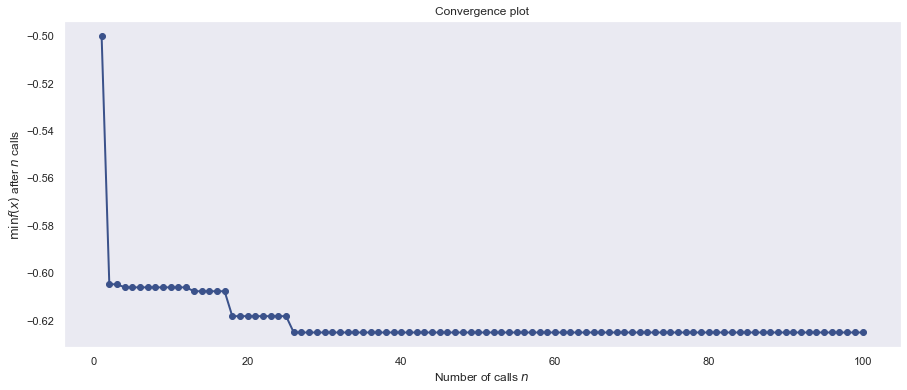

time: 644 ms


In [54]:
plot_convergence(best_output)

We can tell from the plot that ROC_AUC score converges starting from the 45th call.

* Let's get the best estimator's hyper-parameters :

In [55]:
best_output.x

[3, 6, 200, 3.0374684002928483, 0.9, 0.8622368569691512, 0.8100544486656217]

time: 2.14 ms


* Now that we have the best hyper-parameters, let's train a LightGBM model on the entirety of the train set (including the validation set), using these hyper-parameters and predict the target for the test set : 

In [56]:
params = {'max_depth': 50, #maximum depth of tree
              'num_leaves': 6, #number of leaves in full tree 
              'min_child_samples': 200, 
              'scale_pos_weight': 2.7,
              'subsample': 0.9,
              'colsample_bytree': 0.1,
              'learning_rate':0.97, #impact of each tree on the final outcome
              'metric':'binary_logloss', #loss for binary classification
              'nthread': 8,
              'boosting_type': 'gbdt', #traditional Gradient Boosting Decision Tree
              'objective': 'binary', #for binary classification
              'max_bin': 100,
              'min_child_weight': 0,
              'min_split_gain': 0,
              'subsample_freq': 1,
               }
    

num_boost_round = 1000
    
#Create LightGBM datasets for training and testing
xgtrain = lgbm.Dataset(X_train.values, label=y_train, 
                           categorical_feature = cat_features) #Indicate the categorical feature indices
xgtest = lgbm.Dataset(X_test.values, label=y_test,
                            categorical_feature = cat_features)
    
    
# Fit model on train set 
model_lgb = lgbm.train(params,xgtrain, 
                       num_boost_round=num_boost_round)

time: 2.3 s


* Let's look at the feature importances :

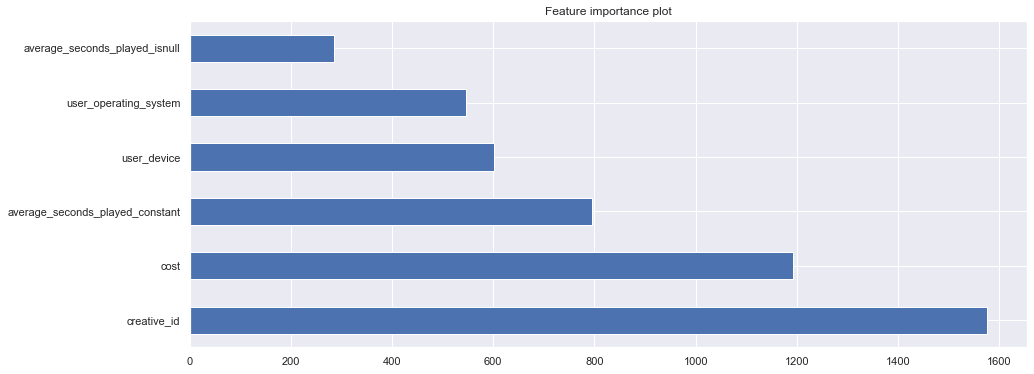

time: 496 ms


In [57]:
(pd.Series(model_lgb.feature_importance(), index=X_train.columns)
   .nlargest(9)
   .plot(kind='barh', title='Feature importance plot')) 

The most important features in this model, by order, the creative_idea, the cost followed by the average_seconds_played. However, the model here seems to take into consideration the user_device, the user_operating_system and the average_seconds_played_isnull more than Random Forest model did.

* Let's use the model to predict our target for the testing set : 

In [58]:
y_pred =  model_lgb.predict(X_test).round()

time: 311 ms


* Let's plot the confusion matrix : 

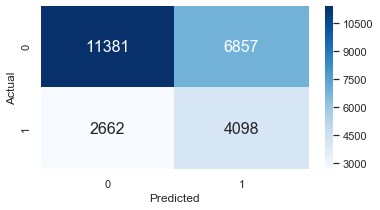

time: 345 ms


In [59]:
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,3))
sns.set(font_scale=1)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size

It looks like the model tends to predict many false positives (6976).

* Let's look at the classification report for this model :

In [60]:
print(classification_report(y_test, y_pred))
print('ROC_AUC score : ' , roc_auc_score(y_test, y_pred))
print('Accuracy score : ' , accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.62      0.71     18238
           1       0.37      0.61      0.46      6760

   micro avg       0.62      0.62      0.62     24998
   macro avg       0.59      0.62      0.58     24998
weighted avg       0.69      0.62      0.64     24998

ROC_AUC score :  0.6151198875356805
Accuracy score :  0.619209536762941
time: 39.1 ms


Overall, the model performs better than Random Forest. The accuracy is lower (**62%** here), but the recall and the f1 score are higher (**61%**, **46%**).

* Let's try another model!

### Catboost

To try and improve on our predictions, we will use CatBoost with Bayesian hyperparameter Optimisation and cross validation. 


Similarly to LightGBM, **CatBoost** is a tree based gradient boosting algorithm. We chose CatBoost because it has great categorical feature support, it offers plot charts with different training statists including evaluation metrics, and it has won many data science competitions.

* Let's start with a simple CatBoost Classifier  :

In [61]:
classifier = catboost.CatBoostClassifier(loss_function='Logloss',#'CrossEntropy',
                                            eval_metric='Accuracy',
                                            #silent=True,
                                            #class_weights=[1, 3],
                                            scale_pos_weight=2.7,
                                            iterations=450,
                                            learning_rate=0.02,
                                            depth=6,
                                            custom_metric=["Precision", "Recall","AUC","F1"])

time: 1.13 ms


* Let's fit our model to the training data : 

In [62]:
classifier.fit(X_train,
                  y_train,
                  eval_set=(X_test, y_test),
                  cat_features=cat_features, #The same as LightGBM
                  plot=True,
                  verbose=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6041434	test: 0.6103124	best: 0.6103124 (0)	total: 114ms	remaining: 51.2s
1:	learn: 0.6043270	test: 0.6086298	best: 0.6103124 (0)	total: 169ms	remaining: 37.9s
2:	learn: 0.6042265	test: 0.6089559	best: 0.6103124 (0)	total: 219ms	remaining: 32.6s
3:	learn: 0.6046741	test: 0.6088791	best: 0.6103124 (0)	total: 298ms	remaining: 33.2s
4:	learn: 0.6047152	test: 0.6092957	best: 0.6103124 (0)	total: 353ms	remaining: 31.4s
5:	learn: 0.6047572	test: 0.6095506	best: 0.6103124 (0)	total: 409ms	remaining: 30.3s
6:	learn: 0.6047289	test: 0.6090929	best: 0.6103124 (0)	total: 445ms	remaining: 28.2s
7:	learn: 0.6047380	test: 0.6090408	best: 0.6103124 (0)	total: 480ms	remaining: 26.5s
8:	learn: 0.6049317	test: 0.6088326	best: 0.6103124 (0)	total: 513ms	remaining: 25.1s
9:	learn: 0.6049061	test: 0.6090436	best: 0.6103124 (0)	total: 550ms	remaining: 24.2s
10:	learn: 0.6048075	test: 0.6090217	best: 0.6103124 (0)	total: 587ms	remaining: 23.4s
11:	learn: 0.6049043	test: 0.6090326	best: 0.6103124 

94:	learn: 0.6094160	test: 0.6119512	best: 0.6122856 (66)	total: 4.3s	remaining: 16.1s
95:	learn: 0.6095292	test: 0.6120060	best: 0.6122856 (66)	total: 4.35s	remaining: 16s
96:	learn: 0.6096461	test: 0.6123020	best: 0.6123020 (96)	total: 4.39s	remaining: 16s
97:	learn: 0.6095018	test: 0.6123541	best: 0.6123541 (97)	total: 4.43s	remaining: 15.9s
98:	learn: 0.6094297	test: 0.6124993	best: 0.6124993 (98)	total: 4.48s	remaining: 15.9s
99:	learn: 0.6093904	test: 0.6123733	best: 0.6124993 (98)	total: 4.53s	remaining: 15.8s
100:	learn: 0.6093465	test: 0.6119731	best: 0.6124993 (98)	total: 4.58s	remaining: 15.8s
101:	learn: 0.6096717	test: 0.6126911	best: 0.6126911 (101)	total: 4.61s	remaining: 15.7s
102:	learn: 0.6098252	test: 0.6126610	best: 0.6126911 (101)	total: 4.65s	remaining: 15.7s
103:	learn: 0.6096352	test: 0.6125733	best: 0.6126911 (101)	total: 4.69s	remaining: 15.6s
104:	learn: 0.6097083	test: 0.6125925	best: 0.6126911 (101)	total: 4.74s	remaining: 15.6s
105:	learn: 0.6098919	test: 

188:	learn: 0.6126232	test: 0.6152014	best: 0.6153412 (185)	total: 8.82s	remaining: 12.2s
189:	learn: 0.6126990	test: 0.6152919	best: 0.6153412 (185)	total: 8.86s	remaining: 12.1s
190:	learn: 0.6126606	test: 0.6151165	best: 0.6153412 (185)	total: 8.9s	remaining: 12.1s
191:	learn: 0.6127666	test: 0.6155221	best: 0.6155221 (191)	total: 8.94s	remaining: 12s
192:	learn: 0.6128004	test: 0.6156563	best: 0.6156563 (192)	total: 8.99s	remaining: 12s
193:	learn: 0.6128132	test: 0.6153028	best: 0.6156563 (192)	total: 9.04s	remaining: 11.9s
194:	learn: 0.6129913	test: 0.6161113	best: 0.6161113 (194)	total: 9.09s	remaining: 11.9s
195:	learn: 0.6130059	test: 0.6158865	best: 0.6161113 (194)	total: 9.12s	remaining: 11.8s
196:	learn: 0.6135522	test: 0.6162565	best: 0.6162565 (196)	total: 9.18s	remaining: 11.8s
197:	learn: 0.6135211	test: 0.6156947	best: 0.6162565 (196)	total: 9.26s	remaining: 11.8s
198:	learn: 0.6135631	test: 0.6162839	best: 0.6162839 (198)	total: 9.33s	remaining: 11.8s
199:	learn: 0.6

283:	learn: 0.6163940	test: 0.6186462	best: 0.6188600 (277)	total: 13.2s	remaining: 7.71s
284:	learn: 0.6164452	test: 0.6187202	best: 0.6188600 (277)	total: 13.3s	remaining: 7.67s
285:	learn: 0.6165438	test: 0.6189203	best: 0.6189203 (285)	total: 13.3s	remaining: 7.63s
286:	learn: 0.6166023	test: 0.6187476	best: 0.6189203 (285)	total: 13.4s	remaining: 7.58s
287:	learn: 0.6165740	test: 0.6188490	best: 0.6189203 (285)	total: 13.4s	remaining: 7.54s
288:	learn: 0.6165438	test: 0.6188572	best: 0.6189203 (285)	total: 13.4s	remaining: 7.49s
289:	learn: 0.6165438	test: 0.6189668	best: 0.6189668 (289)	total: 13.5s	remaining: 7.44s
290:	learn: 0.6166406	test: 0.6188846	best: 0.6189668 (289)	total: 13.5s	remaining: 7.39s
291:	learn: 0.6165767	test: 0.6193121	best: 0.6193121 (291)	total: 13.6s	remaining: 7.34s
292:	learn: 0.6165402	test: 0.6193204	best: 0.6193204 (292)	total: 13.6s	remaining: 7.3s
293:	learn: 0.6165557	test: 0.6193670	best: 0.6193670 (293)	total: 13.7s	remaining: 7.25s
294:	learn:

375:	learn: 0.6178601	test: 0.6197314	best: 0.6202055 (367)	total: 17.4s	remaining: 3.43s
376:	learn: 0.6178419	test: 0.6197040	best: 0.6202055 (367)	total: 17.5s	remaining: 3.38s
377:	learn: 0.6179807	test: 0.6195369	best: 0.6202055 (367)	total: 17.5s	remaining: 3.34s
378:	learn: 0.6179981	test: 0.6195095	best: 0.6202055 (367)	total: 17.6s	remaining: 3.29s
379:	learn: 0.6179515	test: 0.6195369	best: 0.6202055 (367)	total: 17.6s	remaining: 3.24s
380:	learn: 0.6180657	test: 0.6197945	best: 0.6202055 (367)	total: 17.6s	remaining: 3.19s
381:	learn: 0.6182831	test: 0.6194135	best: 0.6202055 (367)	total: 17.7s	remaining: 3.15s
382:	learn: 0.6182831	test: 0.6194135	best: 0.6202055 (367)	total: 17.7s	remaining: 3.1s
383:	learn: 0.6182246	test: 0.6194409	best: 0.6202055 (367)	total: 17.8s	remaining: 3.05s
384:	learn: 0.6182639	test: 0.6194766	best: 0.6202055 (367)	total: 17.8s	remaining: 3.01s
385:	learn: 0.6182694	test: 0.6196520	best: 0.6202055 (367)	total: 17.9s	remaining: 2.96s
386:	learn:

time: 21.7 s


Now let's apply bayesian optimization to search for the best hyper-parameters. We will use the BayesianSearchCV class from scikit-optimizer.

* First, let's define our search space : 

In [63]:
# Defining search space
search_space = {'iterations': Integer(10, 600),
                 'depth': Integer(1, 10),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'random_strength': Real(1e-9, 10, 'log-uniform'),
                 'bagging_temperature': Real(0.0, 1.0),
                 'border_count': Integer(1, 255),
                 'l2_leaf_reg': Integer(2, 30),
                 'scale_pos_weight':Real(1, 3.0, 'uniform')}

time: 7.52 ms


* The main scoring metric is roc-auc :

In [64]:
# Metrics
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)

time: 848 µs


* Because of the imbalanced data, we will use stratified k-fold cross validation : 

In [65]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

time: 1.07 ms


* Let's set up the BayesSearchCV by providing the classifier, the search space, the objective function and the cross validation approach :

In [66]:
# Setting up BayesSearchCV
opt = BayesSearchCV(classifier,
                    search_space,
                    scoring=roc_auc,
                    cv=skf,
                    n_iter=5,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=42)

time: 1.31 ms


In [67]:
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

time: 2.52 ms


* Let's start the optimization :

In [68]:
best_params = report_perf(opt, X_train, y_train, 'CatBoost', 
                           callbacks=[VerboseCallback(100), DeadlineStopper(60*10)]) 

Iteration No: 1 started. Searching for the next optimal point.
0:	learn: 0.5834570	total: 22.7ms	remaining: 4.43s
1:	learn: 0.5880008	total: 41.7ms	remaining: 4.04s
2:	learn: 0.5890742	total: 61.9ms	remaining: 3.98s
3:	learn: 0.5874684	total: 82.8ms	remaining: 3.97s
4:	learn: 0.5883691	total: 104ms	remaining: 3.96s
5:	learn: 0.5892807	total: 125ms	remaining: 3.94s
6:	learn: 0.5883890	total: 149ms	remaining: 4.02s
7:	learn: 0.5881936	total: 169ms	remaining: 3.97s
8:	learn: 0.5891076	total: 191ms	remaining: 3.97s
9:	learn: 0.5898912	total: 210ms	remaining: 3.91s
10:	learn: 0.5905668	total: 230ms	remaining: 3.86s
11:	learn: 0.5913904	total: 250ms	remaining: 3.83s
12:	learn: 0.5920083	total: 270ms	remaining: 3.79s
13:	learn: 0.5927650	total: 288ms	remaining: 3.75s
14:	learn: 0.5931960	total: 309ms	remaining: 3.73s
15:	learn: 0.5941846	total: 330ms	remaining: 3.71s
16:	learn: 0.5978833	total: 350ms	remaining: 3.68s
17:	learn: 0.5974718	total: 370ms	remaining: 3.66s
18:	learn: 0.5981994	tota

163:	learn: 0.6265742	total: 3.37s	remaining: 657ms
164:	learn: 0.6267528	total: 3.39s	remaining: 636ms
165:	learn: 0.6269579	total: 3.41s	remaining: 616ms
166:	learn: 0.6270931	total: 3.43s	remaining: 595ms
167:	learn: 0.6269906	total: 3.45s	remaining: 575ms
168:	learn: 0.6268276	total: 3.47s	remaining: 554ms
169:	learn: 0.6269264	total: 3.49s	remaining: 533ms
170:	learn: 0.6272717	total: 3.5s	remaining: 512ms
171:	learn: 0.6272665	total: 3.53s	remaining: 492ms
172:	learn: 0.6272317	total: 3.55s	remaining: 471ms
173:	learn: 0.6268631	total: 3.56s	remaining: 451ms
174:	learn: 0.6272680	total: 3.58s	remaining: 430ms
175:	learn: 0.6273213	total: 3.6s	remaining: 410ms
176:	learn: 0.6273399	total: 3.63s	remaining: 389ms
177:	learn: 0.6272027	total: 3.65s	remaining: 369ms
178:	learn: 0.6270236	total: 3.67s	remaining: 348ms
179:	learn: 0.6278143	total: 3.69s	remaining: 328ms
180:	learn: 0.6278728	total: 3.71s	remaining: 307ms
181:	learn: 0.6278951	total: 3.73s	remaining: 287ms
182:	learn: 0.

130:	learn: 0.6207644	total: 2.7s	remaining: 1.34s
131:	learn: 0.6205533	total: 2.72s	remaining: 1.32s
132:	learn: 0.6205652	total: 2.74s	remaining: 1.3s
133:	learn: 0.6207781	total: 2.76s	remaining: 1.28s
134:	learn: 0.6206838	total: 2.78s	remaining: 1.26s
135:	learn: 0.6209004	total: 2.81s	remaining: 1.24s
136:	learn: 0.6209246	total: 2.83s	remaining: 1.22s
137:	learn: 0.6210417	total: 2.85s	remaining: 1.2s
138:	learn: 0.6210189	total: 2.87s	remaining: 1.18s
139:	learn: 0.6210784	total: 2.88s	remaining: 1.15s
140:	learn: 0.6211467	total: 2.9s	remaining: 1.13s
141:	learn: 0.6210763	total: 2.92s	remaining: 1.11s
142:	learn: 0.6210406	total: 2.94s	remaining: 1.09s
143:	learn: 0.6210778	total: 2.96s	remaining: 1.07s
144:	learn: 0.6212031	total: 2.98s	remaining: 1.05s
145:	learn: 0.6212559	total: 3s	remaining: 1.03s
146:	learn: 0.6220166	total: 3.03s	remaining: 1.01s
147:	learn: 0.6220079	total: 3.05s	remaining: 988ms
148:	learn: 0.6218898	total: 3.06s	remaining: 967ms
149:	learn: 0.62211

101:	learn: 0.6186371	total: 2.06s	remaining: 1.9s
102:	learn: 0.6189365	total: 2.08s	remaining: 1.88s
103:	learn: 0.6192001	total: 2.1s	remaining: 1.86s
104:	learn: 0.6192182	total: 2.12s	remaining: 1.84s
105:	learn: 0.6191969	total: 2.14s	remaining: 1.82s
106:	learn: 0.6194154	total: 2.16s	remaining: 1.8s
107:	learn: 0.6190674	total: 2.18s	remaining: 1.78s
108:	learn: 0.6191032	total: 2.2s	remaining: 1.76s
109:	learn: 0.6192865	total: 2.22s	remaining: 1.74s
110:	learn: 0.6192326	total: 2.24s	remaining: 1.72s
111:	learn: 0.6197391	total: 2.26s	remaining: 1.7s
112:	learn: 0.6199727	total: 2.28s	remaining: 1.68s
113:	learn: 0.6199390	total: 2.3s	remaining: 1.66s
114:	learn: 0.6201724	total: 2.32s	remaining: 1.64s
115:	learn: 0.6204586	total: 2.34s	remaining: 1.61s
116:	learn: 0.6204581	total: 2.36s	remaining: 1.59s
117:	learn: 0.6204142	total: 2.38s	remaining: 1.57s
118:	learn: 0.6208402	total: 2.4s	remaining: 1.55s
119:	learn: 0.6213248	total: 2.42s	remaining: 1.53s
120:	learn: 0.62133

65:	learn: 0.6110222	total: 1.33s	remaining: 2.63s
66:	learn: 0.6115734	total: 1.35s	remaining: 2.61s
67:	learn: 0.6117238	total: 1.38s	remaining: 2.59s
68:	learn: 0.6116273	total: 1.4s	remaining: 2.57s
69:	learn: 0.6121557	total: 1.42s	remaining: 2.56s
70:	learn: 0.6117333	total: 1.44s	remaining: 2.54s
71:	learn: 0.6121950	total: 1.46s	remaining: 2.52s
72:	learn: 0.6122763	total: 1.49s	remaining: 2.51s
73:	learn: 0.6124004	total: 1.51s	remaining: 2.49s
74:	learn: 0.6124132	total: 1.53s	remaining: 2.48s
75:	learn: 0.6124910	total: 1.56s	remaining: 2.46s
76:	learn: 0.6128658	total: 1.58s	remaining: 2.44s
77:	learn: 0.6131307	total: 1.6s	remaining: 2.42s
78:	learn: 0.6139320	total: 1.62s	remaining: 2.4s
79:	learn: 0.6141215	total: 1.64s	remaining: 2.37s
80:	learn: 0.6144771	total: 1.66s	remaining: 2.35s
81:	learn: 0.6151979	total: 1.68s	remaining: 2.33s
82:	learn: 0.6154287	total: 1.7s	remaining: 2.31s
83:	learn: 0.6155445	total: 1.72s	remaining: 2.29s
84:	learn: 0.6154126	total: 1.74s	r

38:	learn: 0.6065093	total: 767ms	remaining: 3.09s
39:	learn: 0.6064832	total: 785ms	remaining: 3.06s
40:	learn: 0.6066980	total: 804ms	remaining: 3.04s
41:	learn: 0.6068005	total: 824ms	remaining: 3.02s
42:	learn: 0.6071956	total: 844ms	remaining: 3s
43:	learn: 0.6073914	total: 862ms	remaining: 2.98s
44:	learn: 0.6073589	total: 882ms	remaining: 2.96s
45:	learn: 0.6080984	total: 901ms	remaining: 2.94s
46:	learn: 0.6083916	total: 921ms	remaining: 2.92s
47:	learn: 0.6081974	total: 940ms	remaining: 2.9s
48:	learn: 0.6091247	total: 960ms	remaining: 2.88s
49:	learn: 0.6092718	total: 981ms	remaining: 2.86s
50:	learn: 0.6089469	total: 1s	remaining: 2.84s
51:	learn: 0.6094070	total: 1.02s	remaining: 2.83s
52:	learn: 0.6088676	total: 1.04s	remaining: 2.8s
53:	learn: 0.6097403	total: 1.06s	remaining: 2.78s
54:	learn: 0.6103235	total: 1.08s	remaining: 2.77s
55:	learn: 0.6110438	total: 1.1s	remaining: 2.74s
56:	learn: 0.6116861	total: 1.12s	remaining: 2.72s
57:	learn: 0.6119628	total: 1.14s	remain

5:	learn: 0.6206881	total: 156ms	remaining: 14.7s
6:	learn: 0.6207202	total: 180ms	remaining: 14.5s
7:	learn: 0.6206707	total: 207ms	remaining: 14.6s
8:	learn: 0.6206707	total: 233ms	remaining: 14.6s
9:	learn: 0.6206707	total: 259ms	remaining: 14.5s
10:	learn: 0.6206732	total: 285ms	remaining: 14.5s
11:	learn: 0.6206881	total: 307ms	remaining: 14.3s
12:	learn: 0.6206707	total: 334ms	remaining: 14.4s
13:	learn: 0.6206707	total: 361ms	remaining: 14.4s
14:	learn: 0.6206707	total: 386ms	remaining: 14.3s
15:	learn: 0.6206732	total: 412ms	remaining: 14.3s
16:	learn: 0.6206427	total: 436ms	remaining: 14.2s
17:	learn: 0.6206427	total: 463ms	remaining: 14.2s
18:	learn: 0.6208662	total: 489ms	remaining: 14.2s
19:	learn: 0.6207232	total: 512ms	remaining: 14.1s
20:	learn: 0.6207232	total: 537ms	remaining: 14.1s
21:	learn: 0.6207273	total: 561ms	remaining: 14s
22:	learn: 0.6208662	total: 588ms	remaining: 14s
23:	learn: 0.6208802	total: 612ms	remaining: 13.9s
24:	learn: 0.6208802	total: 635ms	remain

173:	learn: 0.6234982	total: 4.24s	remaining: 9.67s
174:	learn: 0.6233672	total: 4.26s	remaining: 9.64s
175:	learn: 0.6233433	total: 4.29s	remaining: 9.62s
176:	learn: 0.6233911	total: 4.31s	remaining: 9.59s
177:	learn: 0.6233631	total: 4.33s	remaining: 9.57s
178:	learn: 0.6233771	total: 4.36s	remaining: 9.55s
179:	learn: 0.6233969	total: 4.39s	remaining: 9.53s
180:	learn: 0.6235047	total: 4.41s	remaining: 9.51s
181:	learn: 0.6237436	total: 4.44s	remaining: 9.49s
182:	learn: 0.6236678	total: 4.47s	remaining: 9.47s
183:	learn: 0.6236958	total: 4.49s	remaining: 9.45s
184:	learn: 0.6236958	total: 4.52s	remaining: 9.42s
185:	learn: 0.6238054	total: 4.54s	remaining: 9.4s
186:	learn: 0.6239436	total: 4.56s	remaining: 9.37s
187:	learn: 0.6239098	total: 4.58s	remaining: 9.34s
188:	learn: 0.6238900	total: 4.61s	remaining: 9.31s
189:	learn: 0.6238900	total: 4.63s	remaining: 9.29s
190:	learn: 0.6238760	total: 4.66s	remaining: 9.27s
191:	learn: 0.6239955	total: 4.68s	remaining: 9.24s
192:	learn: 0

335:	learn: 0.6295658	total: 8.23s	remaining: 5.75s
336:	learn: 0.6295419	total: 8.25s	remaining: 5.73s
337:	learn: 0.6295279	total: 8.28s	remaining: 5.71s
338:	learn: 0.6295262	total: 8.3s	remaining: 5.68s
339:	learn: 0.6294225	total: 8.32s	remaining: 5.65s
340:	learn: 0.6293484	total: 8.34s	remaining: 5.63s
341:	learn: 0.6293764	total: 8.37s	remaining: 5.6s
342:	learn: 0.6293863	total: 8.39s	remaining: 5.58s
343:	learn: 0.6293682	total: 8.41s	remaining: 5.55s
344:	learn: 0.6293781	total: 8.44s	remaining: 5.53s
345:	learn: 0.6293938	total: 8.46s	remaining: 5.5s
346:	learn: 0.6294078	total: 8.49s	remaining: 5.48s
347:	learn: 0.6294235	total: 8.51s	remaining: 5.45s
348:	learn: 0.6294812	total: 8.53s	remaining: 5.43s
349:	learn: 0.6294672	total: 8.56s	remaining: 5.4s
350:	learn: 0.6294812	total: 8.58s	remaining: 5.38s
351:	learn: 0.6295866	total: 8.61s	remaining: 5.35s
352:	learn: 0.6300162	total: 8.63s	remaining: 5.33s
353:	learn: 0.6300162	total: 8.66s	remaining: 5.31s
354:	learn: 0.62

496:	learn: 0.6366692	total: 12.1s	remaining: 1.79s
497:	learn: 0.6367350	total: 12.1s	remaining: 1.77s
498:	learn: 0.6366791	total: 12.1s	remaining: 1.75s
499:	learn: 0.6368067	total: 12.1s	remaining: 1.72s
500:	learn: 0.6372080	total: 12.1s	remaining: 1.7s
501:	learn: 0.6372039	total: 12.2s	remaining: 1.67s
502:	learn: 0.6372913	total: 12.2s	remaining: 1.65s
503:	learn: 0.6372913	total: 12.2s	remaining: 1.62s
504:	learn: 0.6374066	total: 12.2s	remaining: 1.6s
505:	learn: 0.6374206	total: 12.3s	remaining: 1.57s
506:	learn: 0.6374626	total: 12.3s	remaining: 1.55s
507:	learn: 0.6374725	total: 12.3s	remaining: 1.53s
508:	learn: 0.6376257	total: 12.3s	remaining: 1.5s
509:	learn: 0.6375837	total: 12.4s	remaining: 1.48s
510:	learn: 0.6376076	total: 12.4s	remaining: 1.45s
511:	learn: 0.6375417	total: 12.4s	remaining: 1.43s
512:	learn: 0.6374998	total: 12.4s	remaining: 1.41s
513:	learn: 0.6374841	total: 12.5s	remaining: 1.38s
514:	learn: 0.6374800	total: 12.5s	remaining: 1.36s
515:	learn: 0.6

89:	learn: 0.6224805	total: 2.19s	remaining: 11.7s
90:	learn: 0.6225225	total: 2.21s	remaining: 11.7s
91:	learn: 0.6225856	total: 2.23s	remaining: 11.6s
92:	learn: 0.6225856	total: 2.26s	remaining: 11.6s
93:	learn: 0.6225856	total: 2.28s	remaining: 11.6s
94:	learn: 0.6225856	total: 2.3s	remaining: 11.5s
95:	learn: 0.6225856	total: 2.33s	remaining: 11.5s
96:	learn: 0.6225996	total: 2.35s	remaining: 11.5s
97:	learn: 0.6225996	total: 2.37s	remaining: 11.5s
98:	learn: 0.6225996	total: 2.4s	remaining: 11.4s
99:	learn: 0.6225996	total: 2.42s	remaining: 11.4s
100:	learn: 0.6226235	total: 2.44s	remaining: 11.4s
101:	learn: 0.6226392	total: 2.47s	remaining: 11.3s
102:	learn: 0.6226392	total: 2.49s	remaining: 11.3s
103:	learn: 0.6226392	total: 2.51s	remaining: 11.3s
104:	learn: 0.6226392	total: 2.53s	remaining: 11.2s
105:	learn: 0.6226672	total: 2.56s	remaining: 11.2s
106:	learn: 0.6226672	total: 2.58s	remaining: 11.2s
107:	learn: 0.6226672	total: 2.61s	remaining: 11.2s
108:	learn: 0.6226672	tot

249:	learn: 0.6246658	total: 6.01s	remaining: 7.71s
250:	learn: 0.6247968	total: 6.03s	remaining: 7.69s
251:	learn: 0.6247688	total: 6.06s	remaining: 7.67s
252:	learn: 0.6247886	total: 6.08s	remaining: 7.64s
253:	learn: 0.6248323	total: 6.11s	remaining: 7.62s
254:	learn: 0.6249773	total: 6.13s	remaining: 7.59s
255:	learn: 0.6249913	total: 6.15s	remaining: 7.57s
256:	learn: 0.6250152	total: 6.18s	remaining: 7.55s
257:	learn: 0.6250292	total: 6.21s	remaining: 7.53s
258:	learn: 0.6251288	total: 6.23s	remaining: 7.5s
259:	learn: 0.6251009	total: 6.25s	remaining: 7.48s
260:	learn: 0.6251009	total: 6.28s	remaining: 7.46s
261:	learn: 0.6251288	total: 6.3s	remaining: 7.43s
262:	learn: 0.6251527	total: 6.33s	remaining: 7.41s
263:	learn: 0.6251486	total: 6.35s	remaining: 7.38s
264:	learn: 0.6251486	total: 6.37s	remaining: 7.36s
265:	learn: 0.6253455	total: 6.39s	remaining: 7.33s
266:	learn: 0.6253455	total: 6.41s	remaining: 7.3s
267:	learn: 0.6252937	total: 6.43s	remaining: 7.27s
268:	learn: 0.6

408:	learn: 0.6296393	total: 9.79s	remaining: 3.88s
409:	learn: 0.6295874	total: 9.81s	remaining: 3.85s
410:	learn: 0.6295355	total: 9.83s	remaining: 3.83s
411:	learn: 0.6294895	total: 9.85s	remaining: 3.8s
412:	learn: 0.6295134	total: 9.88s	remaining: 3.78s
413:	learn: 0.6294994	total: 9.9s	remaining: 3.75s
414:	learn: 0.6294912	total: 9.92s	remaining: 3.73s
415:	learn: 0.6295191	total: 9.95s	remaining: 3.71s
416:	learn: 0.6294953	total: 9.97s	remaining: 3.68s
417:	learn: 0.6295290	total: 10s	remaining: 3.66s
418:	learn: 0.6295768	total: 10s	remaining: 3.64s
419:	learn: 0.6300736	total: 10s	remaining: 3.61s
420:	learn: 0.6303299	total: 10.1s	remaining: 3.59s
421:	learn: 0.6304190	total: 10.1s	remaining: 3.56s
422:	learn: 0.6304429	total: 10.1s	remaining: 3.54s
423:	learn: 0.6304667	total: 10.1s	remaining: 3.52s
424:	learn: 0.6304527	total: 10.2s	remaining: 3.49s
425:	learn: 0.6304527	total: 10.2s	remaining: 3.47s
426:	learn: 0.6304527	total: 10.2s	remaining: 3.44s
427:	learn: 0.630434

570:	learn: 0.6352656	total: 13.6s	remaining: 0us
0:	learn: 0.6204845	total: 25.9ms	remaining: 14.7s
1:	learn: 0.6204842	total: 51.5ms	remaining: 14.7s
2:	learn: 0.6200219	total: 78.5ms	remaining: 14.9s
3:	learn: 0.6207776	total: 103ms	remaining: 14.6s
4:	learn: 0.6207482	total: 124ms	remaining: 14s
5:	learn: 0.6209106	total: 142ms	remaining: 13.4s
6:	learn: 0.6207482	total: 166ms	remaining: 13.4s
7:	learn: 0.6207482	total: 192ms	remaining: 13.5s
8:	learn: 0.6207482	total: 216ms	remaining: 13.5s
9:	learn: 0.6207482	total: 240ms	remaining: 13.4s
10:	learn: 0.6208438	total: 258ms	remaining: 13.2s
11:	learn: 0.6207905	total: 278ms	remaining: 12.9s
12:	learn: 0.6207905	total: 304ms	remaining: 13s
13:	learn: 0.6207905	total: 324ms	remaining: 12.9s
14:	learn: 0.6207905	total: 346ms	remaining: 12.8s
15:	learn: 0.6208199	total: 370ms	remaining: 12.8s
16:	learn: 0.6208199	total: 392ms	remaining: 12.8s
17:	learn: 0.6208199	total: 414ms	remaining: 12.7s
18:	learn: 0.6208199	total: 435ms	remaining

168:	learn: 0.6227759	total: 4.01s	remaining: 9.54s
169:	learn: 0.6227486	total: 4.04s	remaining: 9.52s
170:	learn: 0.6227998	total: 4.06s	remaining: 9.5s
171:	learn: 0.6228909	total: 4.08s	remaining: 9.47s
172:	learn: 0.6228950	total: 4.11s	remaining: 9.45s
173:	learn: 0.6229247	total: 4.13s	remaining: 9.42s
174:	learn: 0.6230465	total: 4.15s	remaining: 9.4s
175:	learn: 0.6228797	total: 4.17s	remaining: 9.37s
176:	learn: 0.6229537	total: 4.2s	remaining: 9.35s
177:	learn: 0.6231823	total: 4.22s	remaining: 9.33s
178:	learn: 0.6231741	total: 4.25s	remaining: 9.3s
179:	learn: 0.6231642	total: 4.27s	remaining: 9.28s
180:	learn: 0.6231642	total: 4.29s	remaining: 9.25s
181:	learn: 0.6231857	total: 4.31s	remaining: 9.22s
182:	learn: 0.6232096	total: 4.34s	remaining: 9.2s
183:	learn: 0.6232096	total: 4.36s	remaining: 9.17s
184:	learn: 0.6232096	total: 4.38s	remaining: 9.15s
185:	learn: 0.6232697	total: 4.41s	remaining: 9.13s
186:	learn: 0.6232055	total: 4.44s	remaining: 9.11s
187:	learn: 0.623

329:	learn: 0.6266512	total: 7.82s	remaining: 5.71s
330:	learn: 0.6264683	total: 7.84s	remaining: 5.69s
331:	learn: 0.6266710	total: 7.87s	remaining: 5.66s
332:	learn: 0.6266850	total: 7.9s	remaining: 5.64s
333:	learn: 0.6266471	total: 7.92s	remaining: 5.62s
334:	learn: 0.6266710	total: 7.94s	remaining: 5.59s
335:	learn: 0.6267146	total: 7.96s	remaining: 5.57s
336:	learn: 0.6266983	total: 7.99s	remaining: 5.54s
337:	learn: 0.6266744	total: 8.01s	remaining: 5.52s
338:	learn: 0.6266744	total: 8.04s	remaining: 5.5s
339:	learn: 0.6266744	total: 8.06s	remaining: 5.47s
340:	learn: 0.6266382	total: 8.08s	remaining: 5.45s
341:	learn: 0.6266283	total: 8.1s	remaining: 5.42s
342:	learn: 0.6268180	total: 8.12s	remaining: 5.4s
343:	learn: 0.6268419	total: 8.14s	remaining: 5.37s
344:	learn: 0.6268658	total: 8.16s	remaining: 5.35s
345:	learn: 0.6268378	total: 8.19s	remaining: 5.32s
346:	learn: 0.6268477	total: 8.21s	remaining: 5.3s
347:	learn: 0.6267415	total: 8.23s	remaining: 5.27s
348:	learn: 0.627

491:	learn: 0.6329288	total: 11.7s	remaining: 1.88s
492:	learn: 0.6329486	total: 11.7s	remaining: 1.86s
493:	learn: 0.6329387	total: 11.8s	remaining: 1.83s
494:	learn: 0.6329288	total: 11.8s	remaining: 1.81s
495:	learn: 0.6330320	total: 11.8s	remaining: 1.79s
496:	learn: 0.6332883	total: 11.8s	remaining: 1.76s
497:	learn: 0.6333122	total: 11.9s	remaining: 1.74s
498:	learn: 0.6333122	total: 11.9s	remaining: 1.72s
499:	learn: 0.6333518	total: 11.9s	remaining: 1.69s
500:	learn: 0.6333518	total: 11.9s	remaining: 1.67s
501:	learn: 0.6333518	total: 12s	remaining: 1.64s
502:	learn: 0.6333337	total: 12s	remaining: 1.62s
503:	learn: 0.6333337	total: 12s	remaining: 1.6s
504:	learn: 0.6345406	total: 12s	remaining: 1.57s
505:	learn: 0.6344772	total: 12.1s	remaining: 1.55s
506:	learn: 0.6344912	total: 12.1s	remaining: 1.52s
507:	learn: 0.6345052	total: 12.1s	remaining: 1.5s
508:	learn: 0.6345150	total: 12.1s	remaining: 1.48s
509:	learn: 0.6345645	total: 12.2s	remaining: 1.45s
510:	learn: 0.6346543	

85:	learn: 0.6215159	total: 2.04s	remaining: 11.5s
86:	learn: 0.6215299	total: 2.06s	remaining: 11.5s
87:	learn: 0.6215299	total: 2.09s	remaining: 11.5s
88:	learn: 0.6215299	total: 2.11s	remaining: 11.4s
89:	learn: 0.6215299	total: 2.13s	remaining: 11.4s
90:	learn: 0.6215685	total: 2.15s	remaining: 11.3s
91:	learn: 0.6215603	total: 2.17s	remaining: 11.3s
92:	learn: 0.6215685	total: 2.19s	remaining: 11.3s
93:	learn: 0.6215084	total: 2.21s	remaining: 11.2s
94:	learn: 0.6215323	total: 2.24s	remaining: 11.2s
95:	learn: 0.6215002	total: 2.26s	remaining: 11.2s
96:	learn: 0.6214518	total: 2.28s	remaining: 11.2s
97:	learn: 0.6215719	total: 2.3s	remaining: 11.1s
98:	learn: 0.6215422	total: 2.33s	remaining: 11.1s
99:	learn: 0.6216163	total: 2.35s	remaining: 11.1s
100:	learn: 0.6215381	total: 2.37s	remaining: 11s
101:	learn: 0.6215538	total: 2.4s	remaining: 11s
102:	learn: 0.6215538	total: 2.42s	remaining: 11s
103:	learn: 0.6215736	total: 2.45s	remaining: 11s
104:	learn: 0.6215193	total: 2.47s	re

247:	learn: 0.6245328	total: 5.87s	remaining: 7.64s
248:	learn: 0.6245731	total: 5.89s	remaining: 7.62s
249:	learn: 0.6243731	total: 5.92s	remaining: 7.6s
250:	learn: 0.6246291	total: 5.94s	remaining: 7.58s
251:	learn: 0.6246127	total: 5.97s	remaining: 7.55s
252:	learn: 0.6244472	total: 5.99s	remaining: 7.53s
253:	learn: 0.6245188	total: 6.02s	remaining: 7.51s
254:	learn: 0.6245188	total: 6.04s	remaining: 7.49s
255:	learn: 0.6245246	total: 6.07s	remaining: 7.47s
256:	learn: 0.6243922	total: 6.09s	remaining: 7.44s
257:	learn: 0.6244912	total: 6.11s	remaining: 7.41s
258:	learn: 0.6244953	total: 6.13s	remaining: 7.39s
259:	learn: 0.6245218	total: 6.16s	remaining: 7.37s
260:	learn: 0.6245119	total: 6.18s	remaining: 7.34s
261:	learn: 0.6247242	total: 6.21s	remaining: 7.32s
262:	learn: 0.6247539	total: 6.23s	remaining: 7.3s
263:	learn: 0.6246799	total: 6.25s	remaining: 7.27s
264:	learn: 0.6247054	total: 6.28s	remaining: 7.25s
265:	learn: 0.6247054	total: 6.3s	remaining: 7.23s
266:	learn: 0.6

410:	learn: 0.6307909	total: 9.92s	remaining: 3.86s
411:	learn: 0.6307851	total: 9.94s	remaining: 3.83s
412:	learn: 0.6307851	total: 9.96s	remaining: 3.81s
413:	learn: 0.6307711	total: 9.99s	remaining: 3.79s
414:	learn: 0.6307629	total: 10s	remaining: 3.76s
415:	learn: 0.6308025	total: 10s	remaining: 3.74s
416:	learn: 0.6308264	total: 10.1s	remaining: 3.72s
417:	learn: 0.6308725	total: 10.1s	remaining: 3.69s
418:	learn: 0.6308305	total: 10.1s	remaining: 3.67s
419:	learn: 0.6308643	total: 10.1s	remaining: 3.64s
420:	learn: 0.6309032	total: 10.2s	remaining: 3.62s
421:	learn: 0.6309321	total: 10.2s	remaining: 3.6s
422:	learn: 0.6307874	total: 10.2s	remaining: 3.57s
423:	learn: 0.6309250	total: 10.2s	remaining: 3.55s
424:	learn: 0.6310328	total: 10.3s	remaining: 3.52s
425:	learn: 0.6309069	total: 10.3s	remaining: 3.5s
426:	learn: 0.6309710	total: 10.3s	remaining: 3.48s
427:	learn: 0.6309488	total: 10.3s	remaining: 3.46s
428:	learn: 0.6310543	total: 10.4s	remaining: 3.43s
429:	learn: 0.6310

570:	learn: 0.6375527	total: 13.9s	remaining: 0us
0:	learn: 0.6204991	total: 27.8ms	remaining: 15.8s
1:	learn: 0.6207815	total: 52.1ms	remaining: 14.8s
2:	learn: 0.6204882	total: 76.4ms	remaining: 14.5s
3:	learn: 0.6204882	total: 104ms	remaining: 14.7s
4:	learn: 0.6204882	total: 128ms	remaining: 14.5s
5:	learn: 0.6202671	total: 154ms	remaining: 14.5s
6:	learn: 0.6202671	total: 179ms	remaining: 14.4s
7:	learn: 0.6202671	total: 203ms	remaining: 14.3s
8:	learn: 0.6204832	total: 229ms	remaining: 14.3s
9:	learn: 0.6204832	total: 254ms	remaining: 14.2s
10:	learn: 0.6204832	total: 277ms	remaining: 14.1s
11:	learn: 0.6204832	total: 302ms	remaining: 14.1s
12:	learn: 0.6204832	total: 327ms	remaining: 14s
13:	learn: 0.6204832	total: 352ms	remaining: 14s
14:	learn: 0.6204791	total: 379ms	remaining: 14s
15:	learn: 0.6204791	total: 403ms	remaining: 14s
16:	learn: 0.6204791	total: 429ms	remaining: 14s
17:	learn: 0.6204832	total: 454ms	remaining: 14s
18:	learn: 0.6204791	total: 475ms	remaining: 13.8s


166:	learn: 0.6238487	total: 3.93s	remaining: 9.52s
167:	learn: 0.6238067	total: 3.97s	remaining: 9.53s
168:	learn: 0.6239442	total: 4.01s	remaining: 9.54s
169:	learn: 0.6239303	total: 4.03s	remaining: 9.52s
170:	learn: 0.6239303	total: 4.06s	remaining: 9.5s
171:	learn: 0.6239180	total: 4.08s	remaining: 9.47s
172:	learn: 0.6239180	total: 4.11s	remaining: 9.45s
173:	learn: 0.6239418	total: 4.13s	remaining: 9.43s
174:	learn: 0.6239459	total: 4.16s	remaining: 9.41s
175:	learn: 0.6239221	total: 4.18s	remaining: 9.38s
176:	learn: 0.6239459	total: 4.2s	remaining: 9.36s
177:	learn: 0.6238999	total: 4.23s	remaining: 9.34s
178:	learn: 0.6238958	total: 4.25s	remaining: 9.31s
179:	learn: 0.6238661	total: 4.28s	remaining: 9.29s
180:	learn: 0.6238801	total: 4.3s	remaining: 9.27s
181:	learn: 0.6238521	total: 4.32s	remaining: 9.24s
182:	learn: 0.6238381	total: 4.35s	remaining: 9.22s
183:	learn: 0.6238142	total: 4.38s	remaining: 9.2s
184:	learn: 0.6238142	total: 4.4s	remaining: 9.19s
185:	learn: 0.623

326:	learn: 0.6296282	total: 7.76s	remaining: 5.79s
327:	learn: 0.6296660	total: 7.78s	remaining: 5.76s
328:	learn: 0.6296438	total: 7.8s	remaining: 5.74s
329:	learn: 0.6297179	total: 7.82s	remaining: 5.71s
330:	learn: 0.6295879	total: 7.84s	remaining: 5.69s
331:	learn: 0.6296660	total: 7.87s	remaining: 5.67s
332:	learn: 0.6297039	total: 7.89s	remaining: 5.64s
333:	learn: 0.6297039	total: 7.92s	remaining: 5.62s
334:	learn: 0.6296899	total: 7.94s	remaining: 5.59s
335:	learn: 0.6296800	total: 7.97s	remaining: 5.57s
336:	learn: 0.6296537	total: 7.99s	remaining: 5.55s
337:	learn: 0.6296438	total: 8.02s	remaining: 5.53s
338:	learn: 0.6296357	total: 8.04s	remaining: 5.51s
339:	learn: 0.6296316	total: 8.07s	remaining: 5.48s
340:	learn: 0.6296472	total: 8.09s	remaining: 5.46s
341:	learn: 0.6296571	total: 8.12s	remaining: 5.43s
342:	learn: 0.6297510	total: 8.14s	remaining: 5.41s
343:	learn: 0.6298070	total: 8.16s	remaining: 5.39s
344:	learn: 0.6299107	total: 8.19s	remaining: 5.36s
345:	learn: 0

492:	learn: 0.6340739	total: 11.8s	remaining: 1.86s
493:	learn: 0.6341332	total: 11.8s	remaining: 1.84s
494:	learn: 0.6341752	total: 11.8s	remaining: 1.81s
495:	learn: 0.6340674	total: 11.8s	remaining: 1.79s
496:	learn: 0.6341687	total: 11.9s	remaining: 1.77s
497:	learn: 0.6341547	total: 11.9s	remaining: 1.74s
498:	learn: 0.6341145	total: 11.9s	remaining: 1.72s
499:	learn: 0.6340889	total: 11.9s	remaining: 1.7s
500:	learn: 0.6341605	total: 12s	remaining: 1.67s
501:	learn: 0.6342264	total: 12s	remaining: 1.65s
502:	learn: 0.6341984	total: 12s	remaining: 1.62s
503:	learn: 0.6341984	total: 12s	remaining: 1.6s
504:	learn: 0.6342298	total: 12.1s	remaining: 1.58s
505:	learn: 0.6342629	total: 12.1s	remaining: 1.55s
506:	learn: 0.6342175	total: 12.1s	remaining: 1.53s
507:	learn: 0.6342595	total: 12.1s	remaining: 1.5s
508:	learn: 0.6343032	total: 12.2s	remaining: 1.48s
509:	learn: 0.6343270	total: 12.2s	remaining: 1.46s
510:	learn: 0.6342670	total: 12.2s	remaining: 1.43s
511:	learn: 0.6344318	t

84:	learn: 0.5838511	total: 1.62s	remaining: 3.44s
85:	learn: 0.5851332	total: 1.64s	remaining: 3.42s
86:	learn: 0.5851213	total: 1.66s	remaining: 3.41s
87:	learn: 0.5851748	total: 1.68s	remaining: 3.39s
88:	learn: 0.5845995	total: 1.69s	remaining: 3.37s
89:	learn: 0.5845580	total: 1.71s	remaining: 3.35s
90:	learn: 0.5845342	total: 1.74s	remaining: 3.34s
91:	learn: 0.5845148	total: 1.76s	remaining: 3.32s
92:	learn: 0.5845088	total: 1.78s	remaining: 3.31s
93:	learn: 0.5843675	total: 1.8s	remaining: 3.29s
94:	learn: 0.5843150	total: 1.82s	remaining: 3.27s
95:	learn: 0.5847245	total: 1.84s	remaining: 3.25s
96:	learn: 0.5846834	total: 1.86s	remaining: 3.23s
97:	learn: 0.5847488	total: 1.87s	remaining: 3.21s
98:	learn: 0.5898029	total: 1.89s	remaining: 3.19s
99:	learn: 0.5899397	total: 1.91s	remaining: 3.17s
100:	learn: 0.5899634	total: 1.93s	remaining: 3.16s
101:	learn: 0.5901595	total: 1.95s	remaining: 3.14s
102:	learn: 0.5895303	total: 1.97s	remaining: 3.12s
103:	learn: 0.5894535	total: 

246:	learn: 0.6007193	total: 4.77s	remaining: 367ms
247:	learn: 0.6009684	total: 4.79s	remaining: 347ms
248:	learn: 0.6009683	total: 4.8s	remaining: 328ms
249:	learn: 0.6007429	total: 4.82s	remaining: 309ms
250:	learn: 0.6009269	total: 4.84s	remaining: 289ms
251:	learn: 0.6010157	total: 4.86s	remaining: 270ms
252:	learn: 0.6009916	total: 4.88s	remaining: 251ms
253:	learn: 0.6009384	total: 4.9s	remaining: 232ms
254:	learn: 0.6009799	total: 4.92s	remaining: 212ms
255:	learn: 0.6010629	total: 4.94s	remaining: 193ms
256:	learn: 0.6010687	total: 4.96s	remaining: 174ms
257:	learn: 0.6009976	total: 4.98s	remaining: 154ms
258:	learn: 0.6009504	total: 5s	remaining: 135ms
259:	learn: 0.6006652	total: 5.01s	remaining: 116ms
260:	learn: 0.6008319	total: 5.04s	remaining: 96.5ms
261:	learn: 0.6009080	total: 5.05s	remaining: 77.2ms
262:	learn: 0.6007356	total: 5.08s	remaining: 57.9ms
263:	learn: 0.6011931	total: 5.09s	remaining: 38.6ms
264:	learn: 0.6013617	total: 5.12s	remaining: 19.3ms
265:	learn: 

141:	learn: 0.5915911	total: 2.75s	remaining: 2.4s
142:	learn: 0.5916859	total: 2.77s	remaining: 2.38s
143:	learn: 0.5916918	total: 2.79s	remaining: 2.36s
144:	learn: 0.5915906	total: 2.8s	remaining: 2.34s
145:	learn: 0.5920479	total: 2.82s	remaining: 2.32s
146:	learn: 0.5921546	total: 2.84s	remaining: 2.3s
147:	learn: 0.5918700	total: 2.86s	remaining: 2.28s
148:	learn: 0.5919240	total: 2.88s	remaining: 2.26s
149:	learn: 0.5939745	total: 2.9s	remaining: 2.24s
150:	learn: 0.5939510	total: 2.92s	remaining: 2.22s
151:	learn: 0.5941818	total: 2.94s	remaining: 2.2s
152:	learn: 0.5943538	total: 2.96s	remaining: 2.18s
153:	learn: 0.5940929	total: 2.98s	remaining: 2.16s
154:	learn: 0.5941815	total: 3s	remaining: 2.15s
155:	learn: 0.5941580	total: 3.02s	remaining: 2.13s
156:	learn: 0.5943534	total: 3.04s	remaining: 2.11s
157:	learn: 0.5946917	total: 3.06s	remaining: 2.09s
158:	learn: 0.5949350	total: 3.08s	remaining: 2.07s
159:	learn: 0.5947389	total: 3.1s	remaining: 2.06s
160:	learn: 0.5947922

44:	learn: 0.5710454	total: 853ms	remaining: 4.19s
45:	learn: 0.5739132	total: 871ms	remaining: 4.17s
46:	learn: 0.5755385	total: 890ms	remaining: 4.15s
47:	learn: 0.5754498	total: 911ms	remaining: 4.14s
48:	learn: 0.5754085	total: 928ms	remaining: 4.11s
49:	learn: 0.5767749	total: 946ms	remaining: 4.08s
50:	learn: 0.5770250	total: 966ms	remaining: 4.07s
51:	learn: 0.5780288	total: 988ms	remaining: 4.07s
52:	learn: 0.5782766	total: 1.01s	remaining: 4.04s
53:	learn: 0.5788512	total: 1.02s	remaining: 4.02s
54:	learn: 0.5791376	total: 1.04s	remaining: 4s
55:	learn: 0.5782999	total: 1.06s	remaining: 3.98s
56:	learn: 0.5787563	total: 1.08s	remaining: 3.97s
57:	learn: 0.5787155	total: 1.1s	remaining: 3.94s
58:	learn: 0.5792311	total: 1.12s	remaining: 3.93s
59:	learn: 0.5797367	total: 1.14s	remaining: 3.91s
60:	learn: 0.5806617	total: 1.16s	remaining: 3.9s
61:	learn: 0.5802648	total: 1.18s	remaining: 3.88s
62:	learn: 0.5803736	total: 1.2s	remaining: 3.86s
63:	learn: 0.5806393	total: 1.22s	rem

207:	learn: 0.5975574	total: 3.99s	remaining: 1.11s
208:	learn: 0.5975160	total: 4.01s	remaining: 1.09s
209:	learn: 0.5975869	total: 4.03s	remaining: 1.07s
210:	learn: 0.5977350	total: 4.04s	remaining: 1.05s
211:	learn: 0.5975690	total: 4.06s	remaining: 1.03s
212:	learn: 0.5976638	total: 4.08s	remaining: 1.02s
213:	learn: 0.5976698	total: 4.1s	remaining: 997ms
214:	learn: 0.5976628	total: 4.12s	remaining: 977ms
215:	learn: 0.5978064	total: 4.14s	remaining: 958ms
216:	learn: 0.5979608	total: 4.16s	remaining: 939ms
217:	learn: 0.5980145	total: 4.18s	remaining: 920ms
218:	learn: 0.5980086	total: 4.2s	remaining: 901ms
219:	learn: 0.5979551	total: 4.21s	remaining: 881ms
220:	learn: 0.5979311	total: 4.23s	remaining: 862ms
221:	learn: 0.5978711	total: 4.25s	remaining: 843ms
222:	learn: 0.5980381	total: 4.27s	remaining: 824ms
223:	learn: 0.5984717	total: 4.29s	remaining: 804ms
224:	learn: 0.5986022	total: 4.31s	remaining: 785ms
225:	learn: 0.5985665	total: 4.33s	remaining: 766ms
226:	learn: 0.

112:	learn: 0.5899642	total: 2.1s	remaining: 2.84s
113:	learn: 0.5902093	total: 2.12s	remaining: 2.82s
114:	learn: 0.5897700	total: 2.13s	remaining: 2.8s
115:	learn: 0.5897928	total: 2.15s	remaining: 2.78s
116:	learn: 0.5898580	total: 2.17s	remaining: 2.77s
117:	learn: 0.5899704	total: 2.19s	remaining: 2.75s
118:	learn: 0.5899177	total: 2.21s	remaining: 2.73s
119:	learn: 0.5898882	total: 2.23s	remaining: 2.71s
120:	learn: 0.5897936	total: 2.25s	remaining: 2.7s
121:	learn: 0.5901064	total: 2.27s	remaining: 2.68s
122:	learn: 0.5900055	total: 2.29s	remaining: 2.66s
123:	learn: 0.5902845	total: 2.31s	remaining: 2.64s
124:	learn: 0.5910147	total: 2.33s	remaining: 2.62s
125:	learn: 0.5911297	total: 2.34s	remaining: 2.6s
126:	learn: 0.5913791	total: 2.36s	remaining: 2.59s
127:	learn: 0.5919234	total: 2.38s	remaining: 2.57s
128:	learn: 0.5914859	total: 2.4s	remaining: 2.55s
129:	learn: 0.5917770	total: 2.42s	remaining: 2.53s
130:	learn: 0.5917888	total: 2.44s	remaining: 2.51s
131:	learn: 0.591

7:	learn: 0.5588088	total: 153ms	remaining: 4.93s
8:	learn: 0.5588088	total: 171ms	remaining: 4.89s
9:	learn: 0.5588088	total: 189ms	remaining: 4.85s
10:	learn: 0.5586656	total: 209ms	remaining: 4.83s
11:	learn: 0.5649509	total: 227ms	remaining: 4.81s
12:	learn: 0.5651957	total: 247ms	remaining: 4.81s
13:	learn: 0.5663647	total: 266ms	remaining: 4.79s
14:	learn: 0.5683087	total: 288ms	remaining: 4.82s
15:	learn: 0.5685756	total: 308ms	remaining: 4.82s
16:	learn: 0.5689233	total: 327ms	remaining: 4.79s
17:	learn: 0.5705330	total: 347ms	remaining: 4.78s
18:	learn: 0.5705152	total: 367ms	remaining: 4.77s
19:	learn: 0.5704148	total: 385ms	remaining: 4.74s
20:	learn: 0.5705643	total: 405ms	remaining: 4.72s
21:	learn: 0.5708819	total: 425ms	remaining: 4.72s
22:	learn: 0.5710597	total: 443ms	remaining: 4.68s
23:	learn: 0.5710597	total: 463ms	remaining: 4.67s
24:	learn: 0.5711127	total: 483ms	remaining: 4.66s
25:	learn: 0.5713921	total: 503ms	remaining: 4.64s
26:	learn: 0.5716524	total: 522ms	

169:	learn: 0.5964596	total: 3.31s	remaining: 1.87s
170:	learn: 0.5963184	total: 3.33s	remaining: 1.85s
171:	learn: 0.5960090	total: 3.35s	remaining: 1.83s
172:	learn: 0.5961455	total: 3.37s	remaining: 1.81s
173:	learn: 0.5963356	total: 3.39s	remaining: 1.79s
174:	learn: 0.5964067	total: 3.4s	remaining: 1.77s
175:	learn: 0.5962523	total: 3.42s	remaining: 1.75s
176:	learn: 0.5965368	total: 3.44s	remaining: 1.73s
177:	learn: 0.5964656	total: 3.46s	remaining: 1.71s
178:	learn: 0.5966023	total: 3.48s	remaining: 1.69s
179:	learn: 0.5966318	total: 3.5s	remaining: 1.67s
180:	learn: 0.5966914	total: 3.52s	remaining: 1.65s
181:	learn: 0.5970230	total: 3.54s	remaining: 1.63s
182:	learn: 0.5969586	total: 3.55s	remaining: 1.61s
183:	learn: 0.5969111	total: 3.57s	remaining: 1.59s
184:	learn: 0.5969407	total: 3.59s	remaining: 1.57s
185:	learn: 0.5969460	total: 3.61s	remaining: 1.55s
186:	learn: 0.5972666	total: 3.63s	remaining: 1.53s
187:	learn: 0.5978660	total: 3.65s	remaining: 1.51s
188:	learn: 0.

60:	learn: 0.5833080	total: 1.29s	remaining: 8.94s
61:	learn: 0.5833251	total: 1.31s	remaining: 8.89s
62:	learn: 0.5833899	total: 1.32s	remaining: 8.84s
63:	learn: 0.5830205	total: 1.34s	remaining: 8.79s
64:	learn: 0.5835344	total: 1.36s	remaining: 8.75s
65:	learn: 0.5842333	total: 1.37s	remaining: 8.69s
66:	learn: 0.5837816	total: 1.39s	remaining: 8.64s
67:	learn: 0.5845234	total: 1.41s	remaining: 8.6s
68:	learn: 0.5846955	total: 1.42s	remaining: 8.56s
69:	learn: 0.5847009	total: 1.44s	remaining: 8.51s
70:	learn: 0.5844925	total: 1.46s	remaining: 8.47s
71:	learn: 0.5845805	total: 1.47s	remaining: 8.43s
72:	learn: 0.5842334	total: 1.49s	remaining: 8.39s
73:	learn: 0.5838267	total: 1.51s	remaining: 8.36s
74:	learn: 0.5841264	total: 1.52s	remaining: 8.32s
75:	learn: 0.5842850	total: 1.54s	remaining: 8.28s
76:	learn: 0.5847676	total: 1.56s	remaining: 8.24s
77:	learn: 0.5848611	total: 1.58s	remaining: 8.21s
78:	learn: 0.5849639	total: 1.59s	remaining: 8.18s
79:	learn: 0.5851082	total: 1.61

228:	learn: 0.5982814	total: 4.15s	remaining: 4.62s
229:	learn: 0.5985107	total: 4.17s	remaining: 4.6s
230:	learn: 0.5984963	total: 4.18s	remaining: 4.58s
231:	learn: 0.5987656	total: 4.2s	remaining: 4.57s
232:	learn: 0.5986211	total: 4.22s	remaining: 4.54s
233:	learn: 0.5987883	total: 4.24s	remaining: 4.53s
234:	learn: 0.5988704	total: 4.25s	remaining: 4.51s
235:	learn: 0.5990463	total: 4.27s	remaining: 4.49s
236:	learn: 0.5998508	total: 4.29s	remaining: 4.47s
237:	learn: 0.5994896	total: 4.3s	remaining: 4.45s
238:	learn: 0.6000234	total: 4.32s	remaining: 4.43s
239:	learn: 0.6006451	total: 4.34s	remaining: 4.41s
240:	learn: 0.6009277	total: 4.36s	remaining: 4.39s
241:	learn: 0.6009903	total: 4.37s	remaining: 4.37s
242:	learn: 0.6009648	total: 4.39s	remaining: 4.36s
243:	learn: 0.6010385	total: 4.41s	remaining: 4.34s
244:	learn: 0.6011007	total: 4.43s	remaining: 4.32s
245:	learn: 0.6013272	total: 4.44s	remaining: 4.3s
246:	learn: 0.6012734	total: 4.46s	remaining: 4.28s
247:	learn: 0.60

391:	learn: 0.6090985	total: 7.07s	remaining: 1.66s
392:	learn: 0.6090108	total: 7.08s	remaining: 1.64s
393:	learn: 0.6092230	total: 7.1s	remaining: 1.62s
394:	learn: 0.6092061	total: 7.12s	remaining: 1.6s
395:	learn: 0.6092825	total: 7.13s	remaining: 1.58s
396:	learn: 0.6092119	total: 7.15s	remaining: 1.57s
397:	learn: 0.6091588	total: 7.17s	remaining: 1.55s
398:	learn: 0.6091586	total: 7.19s	remaining: 1.53s
399:	learn: 0.6092916	total: 7.21s	remaining: 1.51s
400:	learn: 0.6093340	total: 7.22s	remaining: 1.5s
401:	learn: 0.6092321	total: 7.25s	remaining: 1.48s
402:	learn: 0.6092774	total: 7.28s	remaining: 1.46s
403:	learn: 0.6098874	total: 7.31s	remaining: 1.45s
404:	learn: 0.6099045	total: 7.33s	remaining: 1.43s
405:	learn: 0.6100428	total: 7.36s	remaining: 1.41s
406:	learn: 0.6101221	total: 7.39s	remaining: 1.4s
407:	learn: 0.6100797	total: 7.42s	remaining: 1.38s
408:	learn: 0.6100797	total: 7.44s	remaining: 1.36s
409:	learn: 0.6101139	total: 7.47s	remaining: 1.35s
410:	learn: 0.61

70:	learn: 0.5837801	total: 1.29s	remaining: 7.5s
71:	learn: 0.5838220	total: 1.31s	remaining: 7.48s
72:	learn: 0.5841589	total: 1.32s	remaining: 7.46s
73:	learn: 0.5840485	total: 1.34s	remaining: 7.42s
74:	learn: 0.5840629	total: 1.36s	remaining: 7.39s
75:	learn: 0.5840516	total: 1.37s	remaining: 7.37s
76:	learn: 0.5841307	total: 1.39s	remaining: 7.34s
77:	learn: 0.5841815	total: 1.41s	remaining: 7.33s
78:	learn: 0.5842044	total: 1.43s	remaining: 7.31s
79:	learn: 0.5843139	total: 1.44s	remaining: 7.29s
80:	learn: 0.5844806	total: 1.46s	remaining: 7.27s
81:	learn: 0.5843106	total: 1.48s	remaining: 7.25s
82:	learn: 0.5843674	total: 1.5s	remaining: 7.25s
83:	learn: 0.5844293	total: 1.52s	remaining: 7.23s
84:	learn: 0.5843392	total: 1.53s	remaining: 7.2s
85:	learn: 0.5847258	total: 1.55s	remaining: 7.17s
86:	learn: 0.5846727	total: 1.57s	remaining: 7.15s
87:	learn: 0.5863341	total: 1.58s	remaining: 7.13s
88:	learn: 0.5863501	total: 1.6s	remaining: 7.11s
89:	learn: 0.5848948	total: 1.62s	r

231:	learn: 0.5995092	total: 4.18s	remaining: 4.54s
232:	learn: 0.5993117	total: 4.19s	remaining: 4.52s
233:	learn: 0.5994191	total: 4.21s	remaining: 4.5s
234:	learn: 0.5996225	total: 4.23s	remaining: 4.48s
235:	learn: 0.6006914	total: 4.25s	remaining: 4.46s
236:	learn: 0.6009507	total: 4.26s	remaining: 4.45s
237:	learn: 0.6009647	total: 4.28s	remaining: 4.43s
238:	learn: 0.6010098	total: 4.3s	remaining: 4.41s
239:	learn: 0.6010890	total: 4.32s	remaining: 4.39s
240:	learn: 0.6010835	total: 4.34s	remaining: 4.38s
241:	learn: 0.6011541	total: 4.36s	remaining: 4.36s
242:	learn: 0.6011030	total: 4.37s	remaining: 4.33s
243:	learn: 0.6022243	total: 4.39s	remaining: 4.32s
244:	learn: 0.6028717	total: 4.41s	remaining: 4.3s
245:	learn: 0.6019771	total: 4.43s	remaining: 4.28s
246:	learn: 0.6029117	total: 4.44s	remaining: 4.26s
247:	learn: 0.6017500	total: 4.46s	remaining: 4.24s
248:	learn: 0.6015974	total: 4.48s	remaining: 4.22s
249:	learn: 0.6021760	total: 4.49s	remaining: 4.21s
250:	learn: 0.6

398:	learn: 0.6093403	total: 7.1s	remaining: 1.51s
399:	learn: 0.6092808	total: 7.12s	remaining: 1.49s
400:	learn: 0.6100809	total: 7.13s	remaining: 1.48s
401:	learn: 0.6101573	total: 7.15s	remaining: 1.46s
402:	learn: 0.6100471	total: 7.17s	remaining: 1.44s
403:	learn: 0.6101233	total: 7.18s	remaining: 1.42s
404:	learn: 0.6101464	total: 7.2s	remaining: 1.4s
405:	learn: 0.6101635	total: 7.22s	remaining: 1.39s
406:	learn: 0.6101719	total: 7.24s	remaining: 1.37s
407:	learn: 0.6102370	total: 7.25s	remaining: 1.35s
408:	learn: 0.6103247	total: 7.27s	remaining: 1.33s
409:	learn: 0.6103045	total: 7.29s	remaining: 1.31s
410:	learn: 0.6102536	total: 7.31s	remaining: 1.3s
411:	learn: 0.6104313	total: 7.33s	remaining: 1.28s
412:	learn: 0.6105672	total: 7.34s	remaining: 1.26s
413:	learn: 0.6105983	total: 7.36s	remaining: 1.24s
414:	learn: 0.6106578	total: 7.38s	remaining: 1.23s
415:	learn: 0.6105758	total: 7.4s	remaining: 1.21s
416:	learn: 0.6104456	total: 7.42s	remaining: 1.19s
417:	learn: 0.610

81:	learn: 0.5852926	total: 1.48s	remaining: 7.24s
82:	learn: 0.5854032	total: 1.49s	remaining: 7.21s
83:	learn: 0.5850914	total: 1.51s	remaining: 7.2s
84:	learn: 0.5851423	total: 1.53s	remaining: 7.18s
85:	learn: 0.5852030	total: 1.55s	remaining: 7.16s
86:	learn: 0.5856294	total: 1.56s	remaining: 7.14s
87:	learn: 0.5862676	total: 1.58s	remaining: 7.13s
88:	learn: 0.5863827	total: 1.6s	remaining: 7.11s
89:	learn: 0.5866067	total: 1.62s	remaining: 7.08s
90:	learn: 0.5866201	total: 1.64s	remaining: 7.07s
91:	learn: 0.5868066	total: 1.65s	remaining: 7.05s
92:	learn: 0.5866798	total: 1.67s	remaining: 7.03s
93:	learn: 0.5869400	total: 1.69s	remaining: 7.02s
94:	learn: 0.5869905	total: 1.71s	remaining: 7s
95:	learn: 0.5869431	total: 1.73s	remaining: 6.99s
96:	learn: 0.5871037	total: 1.75s	remaining: 6.97s
97:	learn: 0.5869646	total: 1.76s	remaining: 6.95s
98:	learn: 0.5870017	total: 1.78s	remaining: 6.93s
99:	learn: 0.5869029	total: 1.8s	remaining: 6.93s
100:	learn: 0.5870898	total: 1.82s	re

248:	learn: 0.5986180	total: 4.38s	remaining: 4.13s
249:	learn: 0.5985165	total: 4.39s	remaining: 4.11s
250:	learn: 0.5987232	total: 4.41s	remaining: 4.09s
251:	learn: 0.5988247	total: 4.43s	remaining: 4.08s
252:	learn: 0.5987683	total: 4.44s	remaining: 4.06s
253:	learn: 0.5988447	total: 4.46s	remaining: 4.04s
254:	learn: 0.5991167	total: 4.48s	remaining: 4.02s
255:	learn: 0.5990829	total: 4.5s	remaining: 4s
256:	learn: 0.5989444	total: 4.51s	remaining: 3.99s
257:	learn: 0.5991731	total: 4.53s	remaining: 3.97s
258:	learn: 0.5993713	total: 4.55s	remaining: 3.95s
259:	learn: 0.5996120	total: 4.57s	remaining: 3.93s
260:	learn: 0.5996229	total: 4.58s	remaining: 3.92s
261:	learn: 0.5997754	total: 4.6s	remaining: 3.9s
262:	learn: 0.5996482	total: 4.62s	remaining: 3.88s
263:	learn: 0.5997446	total: 4.63s	remaining: 3.86s
264:	learn: 0.5997728	total: 4.65s	remaining: 3.84s
265:	learn: 0.5995501	total: 4.67s	remaining: 3.83s
266:	learn: 0.5995274	total: 4.69s	remaining: 3.81s
267:	learn: 0.5995

415:	learn: 0.6073741	total: 7.28s	remaining: 1.19s
416:	learn: 0.6075606	total: 7.29s	remaining: 1.17s
417:	learn: 0.6075295	total: 7.31s	remaining: 1.15s
418:	learn: 0.6076148	total: 7.33s	remaining: 1.14s
419:	learn: 0.6076034	total: 7.35s	remaining: 1.12s
420:	learn: 0.6076006	total: 7.37s	remaining: 1.1s
421:	learn: 0.6076203	total: 7.38s	remaining: 1.08s
422:	learn: 0.6075100	total: 7.4s	remaining: 1.07s
423:	learn: 0.6074931	total: 7.42s	remaining: 1.05s
424:	learn: 0.6075837	total: 7.44s	remaining: 1.03s
425:	learn: 0.6073066	total: 7.46s	remaining: 1.01s
426:	learn: 0.6073574	total: 7.47s	remaining: 998ms
427:	learn: 0.6073687	total: 7.49s	remaining: 981ms
428:	learn: 0.6073858	total: 7.51s	remaining: 963ms
429:	learn: 0.6073519	total: 7.53s	remaining: 946ms
430:	learn: 0.6073350	total: 7.55s	remaining: 928ms
431:	learn: 0.6072531	total: 7.57s	remaining: 911ms
432:	learn: 0.6072559	total: 7.58s	remaining: 893ms
433:	learn: 0.6073041	total: 7.6s	remaining: 876ms
434:	learn: 0.6

94:	learn: 0.5856377	total: 1.71s	remaining: 7s
95:	learn: 0.5856264	total: 1.73s	remaining: 6.99s
96:	learn: 0.5855247	total: 1.75s	remaining: 6.97s
97:	learn: 0.5857221	total: 1.76s	remaining: 6.95s
98:	learn: 0.5859259	total: 1.78s	remaining: 6.93s
99:	learn: 0.5859904	total: 1.8s	remaining: 6.91s
100:	learn: 0.5877539	total: 1.82s	remaining: 6.89s
101:	learn: 0.5878669	total: 1.83s	remaining: 6.87s
102:	learn: 0.5878129	total: 1.85s	remaining: 6.85s
103:	learn: 0.5880776	total: 1.87s	remaining: 6.84s
104:	learn: 0.5882339	total: 1.89s	remaining: 6.82s
105:	learn: 0.5879573	total: 1.91s	remaining: 6.8s
106:	learn: 0.5880168	total: 1.93s	remaining: 6.79s
107:	learn: 0.5880199	total: 1.94s	remaining: 6.76s
108:	learn: 0.5880256	total: 1.96s	remaining: 6.74s
109:	learn: 0.5882654	total: 1.98s	remaining: 6.72s
110:	learn: 0.5879160	total: 1.99s	remaining: 6.7s
111:	learn: 0.5879558	total: 2.01s	remaining: 6.68s
112:	learn: 0.5880299	total: 2.03s	remaining: 6.66s
113:	learn: 0.5882075	to

258:	learn: 0.6004346	total: 5.12s	remaining: 4.45s
259:	learn: 0.6005843	total: 5.15s	remaining: 4.43s
260:	learn: 0.6006409	total: 5.17s	remaining: 4.42s
261:	learn: 0.6007362	total: 5.2s	remaining: 4.41s
262:	learn: 0.6006909	total: 5.23s	remaining: 4.39s
263:	learn: 0.6006400	total: 5.25s	remaining: 4.38s
264:	learn: 0.6012068	total: 5.28s	remaining: 4.36s
265:	learn: 0.6011644	total: 5.31s	remaining: 4.35s
266:	learn: 0.6011984	total: 5.33s	remaining: 4.33s
267:	learn: 0.6010825	total: 5.36s	remaining: 4.32s
268:	learn: 0.6009892	total: 5.38s	remaining: 4.3s
269:	learn: 0.6020153	total: 5.41s	remaining: 4.29s
270:	learn: 0.6020492	total: 5.43s	remaining: 4.27s
271:	learn: 0.6022637	total: 5.46s	remaining: 4.26s
272:	learn: 0.6022551	total: 5.49s	remaining: 4.24s
273:	learn: 0.6023002	total: 5.51s	remaining: 4.22s
274:	learn: 0.6022577	total: 5.54s	remaining: 4.21s
275:	learn: 0.6014493	total: 5.56s	remaining: 4.19s
276:	learn: 0.6023426	total: 5.59s	remaining: 4.17s
277:	learn: 0.

418:	learn: 0.6125892	total: 9.36s	remaining: 1.45s
419:	learn: 0.6124311	total: 9.39s	remaining: 1.43s
420:	learn: 0.6124084	total: 9.42s	remaining: 1.41s
421:	learn: 0.6125017	total: 9.45s	remaining: 1.39s
422:	learn: 0.6124819	total: 9.47s	remaining: 1.37s
423:	learn: 0.6124708	total: 9.5s	remaining: 1.34s
424:	learn: 0.6125021	total: 9.53s	remaining: 1.32s
425:	learn: 0.6124541	total: 9.56s	remaining: 1.3s
426:	learn: 0.6124315	total: 9.58s	remaining: 1.28s
427:	learn: 0.6125105	total: 9.61s	remaining: 1.26s
428:	learn: 0.6124513	total: 9.64s	remaining: 1.24s
429:	learn: 0.6124231	total: 9.66s	remaining: 1.21s
430:	learn: 0.6125165	total: 9.69s	remaining: 1.19s
431:	learn: 0.6124939	total: 9.72s	remaining: 1.17s
432:	learn: 0.6124966	total: 9.75s	remaining: 1.15s
433:	learn: 0.6125645	total: 9.77s	remaining: 1.13s
434:	learn: 0.6125731	total: 9.8s	remaining: 1.1s
435:	learn: 0.6121892	total: 9.83s	remaining: 1.08s
436:	learn: 0.6124634	total: 9.86s	remaining: 1.06s
437:	learn: 0.61

99:	learn: 0.5863380	total: 2.77s	remaining: 10.6s
100:	learn: 0.5864505	total: 2.79s	remaining: 10.6s
101:	learn: 0.5866971	total: 2.82s	remaining: 10.6s
102:	learn: 0.5865895	total: 2.85s	remaining: 10.5s
103:	learn: 0.5864531	total: 2.87s	remaining: 10.5s
104:	learn: 0.5864704	total: 2.9s	remaining: 10.5s
105:	learn: 0.5873338	total: 2.92s	remaining: 10.4s
106:	learn: 0.5869375	total: 2.95s	remaining: 10.4s
107:	learn: 0.5871186	total: 2.98s	remaining: 10.4s
108:	learn: 0.5872803	total: 3s	remaining: 10.3s
109:	learn: 0.5872692	total: 3.03s	remaining: 10.3s
110:	learn: 0.5873111	total: 3.06s	remaining: 10.3s
111:	learn: 0.5873309	total: 3.09s	remaining: 10.3s
112:	learn: 0.5871020	total: 3.11s	remaining: 10.2s
113:	learn: 0.5873849	total: 3.14s	remaining: 10.2s
114:	learn: 0.5873709	total: 3.17s	remaining: 10.2s
115:	learn: 0.5874328	total: 3.19s	remaining: 10.1s
116:	learn: 0.5873941	total: 3.22s	remaining: 10.1s
117:	learn: 0.5889372	total: 3.25s	remaining: 10.1s
118:	learn: 0.589

259:	learn: 0.6003294	total: 7.02s	remaining: 6.05s
260:	learn: 0.6003323	total: 7.05s	remaining: 6.02s
261:	learn: 0.6000121	total: 7.08s	remaining: 6s
262:	learn: 0.6002295	total: 7.1s	remaining: 5.97s
263:	learn: 0.6003991	total: 7.13s	remaining: 5.94s
264:	learn: 0.6007521	total: 7.16s	remaining: 5.92s
265:	learn: 0.6007103	total: 7.19s	remaining: 5.89s
266:	learn: 0.6006903	total: 7.21s	remaining: 5.86s
267:	learn: 0.6005835	total: 7.24s	remaining: 5.84s
268:	learn: 0.6015309	total: 7.27s	remaining: 5.81s
269:	learn: 0.6014120	total: 7.3s	remaining: 5.79s
270:	learn: 0.6021017	total: 7.33s	remaining: 5.76s
271:	learn: 0.6016768	total: 7.35s	remaining: 5.73s
272:	learn: 0.6025815	total: 7.38s	remaining: 5.7s
273:	learn: 0.6025844	total: 7.41s	remaining: 5.68s
274:	learn: 0.6024350	total: 7.43s	remaining: 5.65s
275:	learn: 0.6024039	total: 7.46s	remaining: 5.63s
276:	learn: 0.6024072	total: 7.49s	remaining: 5.6s
277:	learn: 0.6026777	total: 7.52s	remaining: 5.57s
278:	learn: 0.60268

424:	learn: 0.6105907	total: 11.6s	remaining: 1.61s
425:	learn: 0.6101873	total: 11.6s	remaining: 1.58s
426:	learn: 0.6108085	total: 11.7s	remaining: 1.56s
427:	learn: 0.6108198	total: 11.7s	remaining: 1.53s
428:	learn: 0.6107405	total: 11.7s	remaining: 1.5s
429:	learn: 0.6106955	total: 11.7s	remaining: 1.48s
430:	learn: 0.6108280	total: 11.8s	remaining: 1.45s
431:	learn: 0.6109474	total: 11.8s	remaining: 1.42s
432:	learn: 0.6109674	total: 11.8s	remaining: 1.39s
433:	learn: 0.6109337	total: 11.9s	remaining: 1.36s
434:	learn: 0.6107869	total: 11.9s	remaining: 1.34s
435:	learn: 0.6109168	total: 11.9s	remaining: 1.31s
436:	learn: 0.6107869	total: 11.9s	remaining: 1.28s
437:	learn: 0.6107193	total: 12s	remaining: 1.26s
438:	learn: 0.6109337	total: 12s	remaining: 1.23s
439:	learn: 0.6109446	total: 12s	remaining: 1.2s
440:	learn: 0.6110866	total: 12s	remaining: 1.17s
441:	learn: 0.6111406	total: 12.1s	remaining: 1.15s
442:	learn: 0.6111317	total: 12.1s	remaining: 1.12s
443:	learn: 0.6112336	

97:	learn: 0.6374055	total: 2.65s	remaining: 9.03s
98:	learn: 0.6373253	total: 2.67s	remaining: 9s
99:	learn: 0.6378286	total: 2.7s	remaining: 8.97s
100:	learn: 0.6379483	total: 2.73s	remaining: 8.95s
101:	learn: 0.6381037	total: 2.76s	remaining: 8.92s
102:	learn: 0.6387116	total: 2.79s	remaining: 8.9s
103:	learn: 0.6390065	total: 2.81s	remaining: 8.86s
104:	learn: 0.6383764	total: 2.84s	remaining: 8.84s
105:	learn: 0.6385824	total: 2.87s	remaining: 8.81s
106:	learn: 0.6387610	total: 2.89s	remaining: 8.78s
107:	learn: 0.6389573	total: 2.92s	remaining: 8.75s
108:	learn: 0.6394162	total: 2.94s	remaining: 8.73s
109:	learn: 0.6397171	total: 2.97s	remaining: 8.7s
110:	learn: 0.6402001	total: 3s	remaining: 8.67s
111:	learn: 0.6404934	total: 3.02s	remaining: 8.64s
112:	learn: 0.6408721	total: 3.05s	remaining: 8.61s
113:	learn: 0.6411498	total: 3.08s	remaining: 8.58s
114:	learn: 0.6416343	total: 3.1s	remaining: 8.55s
115:	learn: 0.6416282	total: 3.13s	remaining: 8.52s
116:	learn: 0.6415145	tot

262:	learn: 0.6560859	total: 7.23s	remaining: 4.65s
263:	learn: 0.6560589	total: 7.26s	remaining: 4.62s
264:	learn: 0.6560984	total: 7.29s	remaining: 4.59s
265:	learn: 0.6561674	total: 7.32s	remaining: 4.57s
266:	learn: 0.6564178	total: 7.35s	remaining: 4.54s
267:	learn: 0.6564548	total: 7.37s	remaining: 4.51s
268:	learn: 0.6566139	total: 7.4s	remaining: 4.48s
269:	learn: 0.6569482	total: 7.43s	remaining: 4.46s
270:	learn: 0.6570075	total: 7.46s	remaining: 4.43s
271:	learn: 0.6570309	total: 7.49s	remaining: 4.4s
272:	learn: 0.6570075	total: 7.51s	remaining: 4.38s
273:	learn: 0.6571012	total: 7.54s	remaining: 4.35s
274:	learn: 0.6575009	total: 7.57s	remaining: 4.32s
275:	learn: 0.6577698	total: 7.6s	remaining: 4.29s
276:	learn: 0.6575997	total: 7.62s	remaining: 4.27s
277:	learn: 0.6578623	total: 7.65s	remaining: 4.24s
278:	learn: 0.6579474	total: 7.68s	remaining: 4.21s
279:	learn: 0.6578734	total: 7.71s	remaining: 4.18s
280:	learn: 0.6583075	total: 7.74s	remaining: 4.16s
281:	learn: 0.6

421:	learn: 0.6662430	total: 11.6s	remaining: 275ms
422:	learn: 0.6664366	total: 11.6s	remaining: 247ms
423:	learn: 0.6663611	total: 11.7s	remaining: 220ms
424:	learn: 0.6663894	total: 11.7s	remaining: 192ms
425:	learn: 0.6664400	total: 11.7s	remaining: 165ms
426:	learn: 0.6665263	total: 11.7s	remaining: 137ms
427:	learn: 0.6664042	total: 11.8s	remaining: 110ms
428:	learn: 0.6668001	total: 11.8s	remaining: 82.4ms
429:	learn: 0.6668285	total: 11.8s	remaining: 54.9ms
430:	learn: 0.6667792	total: 11.8s	remaining: 27.5ms
431:	learn: 0.6668347	total: 11.9s	remaining: 0us
0:	learn: 0.5755464	total: 29.4ms	remaining: 12.7s
1:	learn: 0.5793513	total: 55.8ms	remaining: 12s
2:	learn: 0.5896098	total: 82ms	remaining: 11.7s
3:	learn: 0.5942747	total: 111ms	remaining: 11.9s
4:	learn: 0.5962625	total: 139ms	remaining: 11.9s
5:	learn: 0.5974516	total: 166ms	remaining: 11.8s
6:	learn: 0.5985716	total: 192ms	remaining: 11.7s
7:	learn: 0.5990050	total: 221ms	remaining: 11.7s
8:	learn: 0.6021473	total: 2

153:	learn: 0.6465357	total: 4.26s	remaining: 7.7s
154:	learn: 0.6466037	total: 4.29s	remaining: 7.67s
155:	learn: 0.6464777	total: 4.32s	remaining: 7.65s
156:	learn: 0.6470080	total: 4.35s	remaining: 7.62s
157:	learn: 0.6470129	total: 4.38s	remaining: 7.59s
158:	learn: 0.6466182	total: 4.41s	remaining: 7.56s
159:	learn: 0.6465430	total: 4.43s	remaining: 7.54s
160:	learn: 0.6470128	total: 4.46s	remaining: 7.51s
161:	learn: 0.6473902	total: 4.49s	remaining: 7.49s
162:	learn: 0.6474691	total: 4.52s	remaining: 7.46s
163:	learn: 0.6474001	total: 4.54s	remaining: 7.43s
164:	learn: 0.6473272	total: 4.57s	remaining: 7.4s
165:	learn: 0.6473420	total: 4.6s	remaining: 7.37s
166:	learn: 0.6473222	total: 4.63s	remaining: 7.34s
167:	learn: 0.6474529	total: 4.66s	remaining: 7.32s
168:	learn: 0.6477724	total: 4.68s	remaining: 7.29s
169:	learn: 0.6477601	total: 4.71s	remaining: 7.26s
170:	learn: 0.6477416	total: 4.74s	remaining: 7.24s
171:	learn: 0.6477676	total: 4.77s	remaining: 7.21s
172:	learn: 0.6

314:	learn: 0.6592388	total: 8.73s	remaining: 3.24s
315:	learn: 0.6594398	total: 8.76s	remaining: 3.21s
316:	learn: 0.6593410	total: 8.79s	remaining: 3.19s
317:	learn: 0.6592348	total: 8.81s	remaining: 3.16s
318:	learn: 0.6592286	total: 8.84s	remaining: 3.13s
319:	learn: 0.6593409	total: 8.87s	remaining: 3.1s
320:	learn: 0.6593397	total: 8.9s	remaining: 3.08s
321:	learn: 0.6594396	total: 8.93s	remaining: 3.05s
322:	learn: 0.6595370	total: 8.96s	remaining: 3.02s
323:	learn: 0.6595320	total: 8.98s	remaining: 2.99s
324:	learn: 0.6597639	total: 9.01s	remaining: 2.97s
325:	learn: 0.6595567	total: 9.04s	remaining: 2.94s
326:	learn: 0.6594630	total: 9.06s	remaining: 2.91s
327:	learn: 0.6595457	total: 9.09s	remaining: 2.88s
328:	learn: 0.6594089	total: 9.12s	remaining: 2.85s
329:	learn: 0.6594915	total: 9.15s	remaining: 2.83s
330:	learn: 0.6595186	total: 9.18s	remaining: 2.8s
331:	learn: 0.6595505	total: 9.2s	remaining: 2.77s
332:	learn: 0.6596517	total: 9.23s	remaining: 2.74s
333:	learn: 0.65

48:	learn: 0.6269057	total: 1.42s	remaining: 11.1s
49:	learn: 0.6268696	total: 1.45s	remaining: 11.1s
50:	learn: 0.6272013	total: 1.48s	remaining: 11.1s
51:	learn: 0.6278256	total: 1.51s	remaining: 11s
52:	learn: 0.6288776	total: 1.54s	remaining: 11s
53:	learn: 0.6296306	total: 1.56s	remaining: 11s
54:	learn: 0.6300893	total: 1.59s	remaining: 10.9s
55:	learn: 0.6301918	total: 1.63s	remaining: 10.9s
56:	learn: 0.6305950	total: 1.65s	remaining: 10.9s
57:	learn: 0.6311402	total: 1.68s	remaining: 10.9s
58:	learn: 0.6312845	total: 1.71s	remaining: 10.8s
59:	learn: 0.6311512	total: 1.74s	remaining: 10.8s
60:	learn: 0.6317651	total: 1.77s	remaining: 10.8s
61:	learn: 0.6317467	total: 1.8s	remaining: 10.7s
62:	learn: 0.6317603	total: 1.83s	remaining: 10.7s
63:	learn: 0.6322660	total: 1.86s	remaining: 10.7s
64:	learn: 0.6323820	total: 1.89s	remaining: 10.7s
65:	learn: 0.6322932	total: 1.92s	remaining: 10.6s
66:	learn: 0.6321601	total: 1.94s	remaining: 10.6s
67:	learn: 0.6321354	total: 1.97s	rema

213:	learn: 0.6530548	total: 6.05s	remaining: 6.16s
214:	learn: 0.6527711	total: 6.07s	remaining: 6.13s
215:	learn: 0.6532707	total: 6.1s	remaining: 6.1s
216:	learn: 0.6533632	total: 6.13s	remaining: 6.08s
217:	learn: 0.6534421	total: 6.16s	remaining: 6.04s
218:	learn: 0.6534791	total: 6.19s	remaining: 6.02s
219:	learn: 0.6531915	total: 6.21s	remaining: 5.99s
220:	learn: 0.6532334	total: 6.24s	remaining: 5.96s
221:	learn: 0.6535244	total: 6.27s	remaining: 5.93s
222:	learn: 0.6539363	total: 6.3s	remaining: 5.9s
223:	learn: 0.6540584	total: 6.33s	remaining: 5.88s
224:	learn: 0.6540658	total: 6.36s	remaining: 5.85s
225:	learn: 0.6538843	total: 6.39s	remaining: 5.82s
226:	learn: 0.6539052	total: 6.41s	remaining: 5.79s
227:	learn: 0.6535759	total: 6.44s	remaining: 5.76s
228:	learn: 0.6535820	total: 6.47s	remaining: 5.74s
229:	learn: 0.6537213	total: 6.5s	remaining: 5.71s
230:	learn: 0.6538226	total: 6.53s	remaining: 5.68s
231:	learn: 0.6538496	total: 6.56s	remaining: 5.65s
232:	learn: 0.653

378:	learn: 0.6642187	total: 10.6s	remaining: 1.48s
379:	learn: 0.6643062	total: 10.6s	remaining: 1.45s
380:	learn: 0.6642926	total: 10.6s	remaining: 1.42s
381:	learn: 0.6642069	total: 10.7s	remaining: 1.39s
382:	learn: 0.6644079	total: 10.7s	remaining: 1.37s
383:	learn: 0.6644708	total: 10.7s	remaining: 1.34s
384:	learn: 0.6644980	total: 10.7s	remaining: 1.31s
385:	learn: 0.6644375	total: 10.8s	remaining: 1.28s
386:	learn: 0.6644375	total: 10.8s	remaining: 1.25s
387:	learn: 0.6647803	total: 10.8s	remaining: 1.23s
388:	learn: 0.6649378	total: 10.8s	remaining: 1.2s
389:	learn: 0.6650919	total: 10.9s	remaining: 1.17s
390:	learn: 0.6651031	total: 10.9s	remaining: 1.14s
391:	learn: 0.6653374	total: 10.9s	remaining: 1.11s
392:	learn: 0.6653053	total: 11s	remaining: 1.09s
393:	learn: 0.6654607	total: 11s	remaining: 1.06s
394:	learn: 0.6655187	total: 11s	remaining: 1.03s
395:	learn: 0.6656001	total: 11s	remaining: 1s
396:	learn: 0.6655236	total: 11.1s	remaining: 976ms
397:	learn: 0.6656765	to

112:	learn: 0.6389848	total: 3.28s	remaining: 9.26s
113:	learn: 0.6390108	total: 3.31s	remaining: 9.23s
114:	learn: 0.6394065	total: 3.34s	remaining: 9.2s
115:	learn: 0.6396668	total: 3.37s	remaining: 9.17s
116:	learn: 0.6400752	total: 3.4s	remaining: 9.14s
117:	learn: 0.6402887	total: 3.42s	remaining: 9.11s
118:	learn: 0.6404488	total: 3.45s	remaining: 9.08s
119:	learn: 0.6404045	total: 3.48s	remaining: 9.04s
120:	learn: 0.6406524	total: 3.51s	remaining: 9.02s
121:	learn: 0.6409643	total: 3.54s	remaining: 8.99s
122:	learn: 0.6412148	total: 3.56s	remaining: 8.96s
123:	learn: 0.6415551	total: 3.6s	remaining: 8.93s
124:	learn: 0.6419511	total: 3.62s	remaining: 8.89s
125:	learn: 0.6418832	total: 3.65s	remaining: 8.87s
126:	learn: 0.6422382	total: 3.68s	remaining: 8.84s
127:	learn: 0.6421459	total: 3.71s	remaining: 8.81s
128:	learn: 0.6423234	total: 3.74s	remaining: 8.78s
129:	learn: 0.6426168	total: 3.77s	remaining: 8.75s
130:	learn: 0.6426489	total: 3.8s	remaining: 8.73s
131:	learn: 0.64

273:	learn: 0.6569534	total: 7.88s	remaining: 4.55s
274:	learn: 0.6572013	total: 7.91s	remaining: 4.51s
275:	learn: 0.6571284	total: 7.94s	remaining: 4.49s
276:	learn: 0.6570951	total: 7.96s	remaining: 4.46s
277:	learn: 0.6570507	total: 7.99s	remaining: 4.43s
278:	learn: 0.6571630	total: 8.02s	remaining: 4.4s
279:	learn: 0.6572111	total: 8.05s	remaining: 4.37s
280:	learn: 0.6572122	total: 8.08s	remaining: 4.34s
281:	learn: 0.6573331	total: 8.11s	remaining: 4.31s
282:	learn: 0.6576574	total: 8.13s	remaining: 4.28s
283:	learn: 0.6579448	total: 8.16s	remaining: 4.25s
284:	learn: 0.6579325	total: 8.19s	remaining: 4.22s
285:	learn: 0.6579105	total: 8.21s	remaining: 4.19s
286:	learn: 0.6578355	total: 8.24s	remaining: 4.16s
287:	learn: 0.6577368	total: 8.27s	remaining: 4.13s
288:	learn: 0.6582696	total: 8.3s	remaining: 4.11s
289:	learn: 0.6581784	total: 8.33s	remaining: 4.08s
290:	learn: 0.6581833	total: 8.36s	remaining: 4.05s
291:	learn: 0.6584904	total: 8.38s	remaining: 4.02s
292:	learn: 0.

0:	learn: 0.5756735	total: 30.6ms	remaining: 13.2s
1:	learn: 0.5805630	total: 58.4ms	remaining: 12.5s
2:	learn: 0.5854767	total: 87ms	remaining: 12.4s
3:	learn: 0.5933354	total: 116ms	remaining: 12.4s
4:	learn: 0.5933283	total: 142ms	remaining: 12.1s
5:	learn: 0.5974312	total: 169ms	remaining: 12s
6:	learn: 0.5982072	total: 198ms	remaining: 12s
7:	learn: 0.6002910	total: 228ms	remaining: 12.1s
8:	learn: 0.6032611	total: 259ms	remaining: 12.2s
9:	learn: 0.6037025	total: 287ms	remaining: 12.1s
10:	learn: 0.6036912	total: 317ms	remaining: 12.1s
11:	learn: 0.6048543	total: 346ms	remaining: 12.1s
12:	learn: 0.6056109	total: 375ms	remaining: 12.1s
13:	learn: 0.6087338	total: 402ms	remaining: 12s
14:	learn: 0.6088314	total: 432ms	remaining: 12s
15:	learn: 0.6090775	total: 461ms	remaining: 12s
16:	learn: 0.6099340	total: 490ms	remaining: 12s
17:	learn: 0.6112834	total: 518ms	remaining: 11.9s
18:	learn: 0.6115566	total: 547ms	remaining: 11.9s
19:	learn: 0.6125694	total: 578ms	remaining: 11.9s
2

164:	learn: 0.6477739	total: 4.77s	remaining: 7.72s
165:	learn: 0.6479416	total: 4.8s	remaining: 7.69s
166:	learn: 0.6480983	total: 4.82s	remaining: 7.65s
167:	learn: 0.6481908	total: 4.85s	remaining: 7.63s
168:	learn: 0.6481478	total: 4.88s	remaining: 7.59s
169:	learn: 0.6483796	total: 4.91s	remaining: 7.57s
170:	learn: 0.6481761	total: 4.94s	remaining: 7.54s
171:	learn: 0.6483068	total: 4.96s	remaining: 7.5s
172:	learn: 0.6488149	total: 4.99s	remaining: 7.47s
173:	learn: 0.6488185	total: 5.02s	remaining: 7.44s
174:	learn: 0.6487285	total: 5.05s	remaining: 7.41s
175:	learn: 0.6489260	total: 5.08s	remaining: 7.38s
176:	learn: 0.6488840	total: 5.11s	remaining: 7.36s
177:	learn: 0.6488840	total: 5.13s	remaining: 7.32s
178:	learn: 0.6490691	total: 5.16s	remaining: 7.29s
179:	learn: 0.6492047	total: 5.19s	remaining: 7.26s
180:	learn: 0.6488936	total: 5.22s	remaining: 7.24s
181:	learn: 0.6490861	total: 5.25s	remaining: 7.21s
182:	learn: 0.6491577	total: 5.28s	remaining: 7.18s
183:	learn: 0.

323:	learn: 0.6602401	total: 9.29s	remaining: 3.1s
324:	learn: 0.6602401	total: 9.32s	remaining: 3.07s
325:	learn: 0.6604017	total: 9.35s	remaining: 3.04s
326:	learn: 0.6604633	total: 9.37s	remaining: 3.01s
327:	learn: 0.6604189	total: 9.4s	remaining: 2.98s
328:	learn: 0.6603733	total: 9.43s	remaining: 2.95s
329:	learn: 0.6603782	total: 9.46s	remaining: 2.92s
330:	learn: 0.6604313	total: 9.48s	remaining: 2.89s
331:	learn: 0.6604633	total: 9.51s	remaining: 2.87s
332:	learn: 0.6603905	total: 9.54s	remaining: 2.84s
333:	learn: 0.6604275	total: 9.57s	remaining: 2.81s
334:	learn: 0.6603954	total: 9.6s	remaining: 2.78s
335:	learn: 0.6604484	total: 9.63s	remaining: 2.75s
336:	learn: 0.6605435	total: 9.65s	remaining: 2.72s
337:	learn: 0.6608086	total: 9.68s	remaining: 2.69s
338:	learn: 0.6610121	total: 9.71s	remaining: 2.66s
339:	learn: 0.6610245	total: 9.74s	remaining: 2.63s
340:	learn: 0.6609494	total: 9.77s	remaining: 2.61s
341:	learn: 0.6610147	total: 9.8s	remaining: 2.58s
342:	learn: 0.66

49:	learn: 0.6271564	total: 1.54s	remaining: 11.8s
50:	learn: 0.6271852	total: 1.57s	remaining: 11.7s
51:	learn: 0.6273490	total: 1.6s	remaining: 11.7s
52:	learn: 0.6272925	total: 1.63s	remaining: 11.6s
53:	learn: 0.6273923	total: 1.66s	remaining: 11.6s
54:	learn: 0.6277564	total: 1.69s	remaining: 11.6s
55:	learn: 0.6278689	total: 1.72s	remaining: 11.6s
56:	learn: 0.6279448	total: 1.75s	remaining: 11.5s
57:	learn: 0.6285290	total: 1.78s	remaining: 11.5s
58:	learn: 0.6283280	total: 1.81s	remaining: 11.5s
59:	learn: 0.6283656	total: 1.84s	remaining: 11.4s
60:	learn: 0.6294203	total: 1.88s	remaining: 11.4s
61:	learn: 0.6302232	total: 1.91s	remaining: 11.4s
62:	learn: 0.6309435	total: 1.94s	remaining: 11.4s
63:	learn: 0.6309446	total: 1.97s	remaining: 11.3s
64:	learn: 0.6310364	total: 2s	remaining: 11.3s
65:	learn: 0.6317351	total: 2.03s	remaining: 11.3s
66:	learn: 0.6321327	total: 2.06s	remaining: 11.3s
67:	learn: 0.6320963	total: 2.1s	remaining: 11.2s
68:	learn: 0.6321181	total: 2.12s	re

209:	learn: 0.6486964	total: 6.56s	remaining: 6.93s
210:	learn: 0.6487704	total: 6.59s	remaining: 6.9s
211:	learn: 0.6487595	total: 6.62s	remaining: 6.87s
212:	learn: 0.6491217	total: 6.65s	remaining: 6.84s
213:	learn: 0.6493447	total: 6.68s	remaining: 6.81s
214:	learn: 0.6494789	total: 6.71s	remaining: 6.78s
215:	learn: 0.6493516	total: 6.74s	remaining: 6.74s
216:	learn: 0.6495450	total: 6.78s	remaining: 6.71s
217:	learn: 0.6495844	total: 6.81s	remaining: 6.68s
218:	learn: 0.6497009	total: 6.84s	remaining: 6.65s
219:	learn: 0.6497927	total: 6.87s	remaining: 6.62s
220:	learn: 0.6497710	total: 6.91s	remaining: 6.59s
221:	learn: 0.6496872	total: 6.94s	remaining: 6.56s
222:	learn: 0.6496043	total: 6.97s	remaining: 6.53s
223:	learn: 0.6497680	total: 7s	remaining: 6.5s
224:	learn: 0.6496044	total: 7.03s	remaining: 6.47s
225:	learn: 0.6495550	total: 7.06s	remaining: 6.44s
226:	learn: 0.6495768	total: 7.09s	remaining: 6.4s
227:	learn: 0.6499694	total: 7.12s	remaining: 6.37s
228:	learn: 0.6502

370:	learn: 0.6585127	total: 11.5s	remaining: 1.9s
371:	learn: 0.6585522	total: 11.6s	remaining: 1.86s
372:	learn: 0.6585917	total: 11.6s	remaining: 1.83s
373:	learn: 0.6585817	total: 11.6s	remaining: 1.8s
374:	learn: 0.6585679	total: 11.7s	remaining: 1.77s
375:	learn: 0.6585946	total: 11.7s	remaining: 1.74s
376:	learn: 0.6585659	total: 11.7s	remaining: 1.71s
377:	learn: 0.6586646	total: 11.8s	remaining: 1.68s
378:	learn: 0.6585786	total: 11.8s	remaining: 1.65s
379:	learn: 0.6588775	total: 11.8s	remaining: 1.62s
380:	learn: 0.6589297	total: 11.8s	remaining: 1.58s
381:	learn: 0.6590124	total: 11.9s	remaining: 1.55s
382:	learn: 0.6588891	total: 11.9s	remaining: 1.52s
383:	learn: 0.6589296	total: 11.9s	remaining: 1.49s
384:	learn: 0.6592039	total: 12s	remaining: 1.46s
385:	learn: 0.6592444	total: 12s	remaining: 1.43s
386:	learn: 0.6594289	total: 12s	remaining: 1.4s
387:	learn: 0.6594882	total: 12.1s	remaining: 1.37s
388:	learn: 0.6594201	total: 12.1s	remaining: 1.34s
389:	learn: 0.6595237

* Let's train a CatBoostClassifier using the best parameters found during the optimization :

In [69]:
%%time
tuned_model = catboost.CatBoostClassifier(**best_params)
tuned_model.fit(X_train,
                  y_train,
                  eval_set=(X_test, y_test),
                  cat_features=cat_features,
                  plot=True,
                  verbose=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6740197	test: 0.6723864	best: 0.6723864 (0)	total: 74.2ms	remaining: 32s
1:	learn: 0.6641102	test: 0.6616492	best: 0.6616492 (1)	total: 128ms	remaining: 27.5s
2:	learn: 0.6581905	test: 0.6551479	best: 0.6551479 (2)	total: 187ms	remaining: 26.7s
3:	learn: 0.6544341	test: 0.6509703	best: 0.6509703 (3)	total: 243ms	remaining: 26s
4:	learn: 0.6518014	test: 0.6480850	best: 0.6480850 (4)	total: 290ms	remaining: 24.8s
5:	learn: 0.6505741	test: 0.6466820	best: 0.6466820 (5)	total: 334ms	remaining: 23.7s
6:	learn: 0.6495625	test: 0.6455660	best: 0.6455660 (6)	total: 375ms	remaining: 22.8s
7:	learn: 0.6486047	test: 0.6443410	best: 0.6443410 (7)	total: 419ms	remaining: 22.2s
8:	learn: 0.6478317	test: 0.6433318	best: 0.6433318 (8)	total: 459ms	remaining: 21.6s
9:	learn: 0.6473287	test: 0.6427582	best: 0.6427582 (9)	total: 505ms	remaining: 21.3s
10:	learn: 0.6469381	test: 0.6425306	best: 0.6425306 (10)	total: 550ms	remaining: 21s
11:	learn: 0.6462377	test: 0.6421736	best: 0.6421736 (11)

97:	learn: 0.6337926	test: 0.6383830	best: 0.6383280 (95)	total: 4.93s	remaining: 16.8s
98:	learn: 0.6337857	test: 0.6383836	best: 0.6383280 (95)	total: 4.98s	remaining: 16.8s
99:	learn: 0.6336941	test: 0.6382751	best: 0.6382751 (99)	total: 5.03s	remaining: 16.7s
100:	learn: 0.6336927	test: 0.6382752	best: 0.6382751 (99)	total: 5.07s	remaining: 16.6s
101:	learn: 0.6336706	test: 0.6382708	best: 0.6382708 (101)	total: 5.1s	remaining: 16.5s
102:	learn: 0.6336628	test: 0.6382705	best: 0.6382705 (102)	total: 5.14s	remaining: 16.4s
103:	learn: 0.6336135	test: 0.6382752	best: 0.6382705 (102)	total: 5.18s	remaining: 16.3s
104:	learn: 0.6335216	test: 0.6382799	best: 0.6382705 (102)	total: 5.24s	remaining: 16.3s
105:	learn: 0.6334676	test: 0.6382709	best: 0.6382705 (102)	total: 5.3s	remaining: 16.3s
106:	learn: 0.6333613	test: 0.6382034	best: 0.6382034 (106)	total: 5.34s	remaining: 16.2s
107:	learn: 0.6332612	test: 0.6382251	best: 0.6382034 (106)	total: 5.38s	remaining: 16.1s
108:	learn: 0.63308

189:	learn: 0.6277027	test: 0.6387629	best: 0.6382034 (106)	total: 9.61s	remaining: 12.2s
190:	learn: 0.6275952	test: 0.6387982	best: 0.6382034 (106)	total: 9.68s	remaining: 12.2s
191:	learn: 0.6274861	test: 0.6387926	best: 0.6382034 (106)	total: 9.75s	remaining: 12.2s
192:	learn: 0.6273736	test: 0.6387354	best: 0.6382034 (106)	total: 9.85s	remaining: 12.2s
193:	learn: 0.6273621	test: 0.6387344	best: 0.6382034 (106)	total: 9.92s	remaining: 12.2s
194:	learn: 0.6273408	test: 0.6387366	best: 0.6382034 (106)	total: 9.96s	remaining: 12.1s
195:	learn: 0.6272460	test: 0.6387342	best: 0.6382034 (106)	total: 10s	remaining: 12.1s
196:	learn: 0.6272232	test: 0.6387615	best: 0.6382034 (106)	total: 10.1s	remaining: 12s
197:	learn: 0.6271569	test: 0.6387684	best: 0.6382034 (106)	total: 10.1s	remaining: 11.9s
198:	learn: 0.6270116	test: 0.6387184	best: 0.6382034 (106)	total: 10.2s	remaining: 11.9s
199:	learn: 0.6270016	test: 0.6387283	best: 0.6382034 (106)	total: 10.2s	remaining: 11.8s
200:	learn: 0.

281:	learn: 0.6222448	test: 0.6396641	best: 0.6382034 (106)	total: 14.3s	remaining: 7.62s
282:	learn: 0.6221850	test: 0.6397216	best: 0.6382034 (106)	total: 14.4s	remaining: 7.57s
283:	learn: 0.6221072	test: 0.6397133	best: 0.6382034 (106)	total: 14.4s	remaining: 7.53s
284:	learn: 0.6220694	test: 0.6397144	best: 0.6382034 (106)	total: 14.5s	remaining: 7.47s
285:	learn: 0.6219905	test: 0.6397651	best: 0.6382034 (106)	total: 14.5s	remaining: 7.42s
286:	learn: 0.6219475	test: 0.6397468	best: 0.6382034 (106)	total: 14.6s	remaining: 7.37s
287:	learn: 0.6218297	test: 0.6396701	best: 0.6382034 (106)	total: 14.6s	remaining: 7.32s
288:	learn: 0.6217320	test: 0.6396330	best: 0.6382034 (106)	total: 14.7s	remaining: 7.28s
289:	learn: 0.6216732	test: 0.6396503	best: 0.6382034 (106)	total: 14.8s	remaining: 7.23s
290:	learn: 0.6216530	test: 0.6396553	best: 0.6382034 (106)	total: 14.8s	remaining: 7.18s
291:	learn: 0.6216092	test: 0.6396425	best: 0.6382034 (106)	total: 14.9s	remaining: 7.13s
292:	learn

373:	learn: 0.6176720	test: 0.6401707	best: 0.6382034 (106)	total: 19s	remaining: 2.95s
374:	learn: 0.6176719	test: 0.6401707	best: 0.6382034 (106)	total: 19.1s	remaining: 2.9s
375:	learn: 0.6175977	test: 0.6401849	best: 0.6382034 (106)	total: 19.1s	remaining: 2.85s
376:	learn: 0.6175741	test: 0.6401910	best: 0.6382034 (106)	total: 19.2s	remaining: 2.8s
377:	learn: 0.6175740	test: 0.6401911	best: 0.6382034 (106)	total: 19.2s	remaining: 2.75s
378:	learn: 0.6175391	test: 0.6401956	best: 0.6382034 (106)	total: 19.3s	remaining: 2.7s
379:	learn: 0.6174027	test: 0.6401778	best: 0.6382034 (106)	total: 19.3s	remaining: 2.65s
380:	learn: 0.6173494	test: 0.6402180	best: 0.6382034 (106)	total: 19.4s	remaining: 2.6s
381:	learn: 0.6172866	test: 0.6402341	best: 0.6382034 (106)	total: 19.5s	remaining: 2.55s
382:	learn: 0.6171462	test: 0.6402717	best: 0.6382034 (106)	total: 19.5s	remaining: 2.49s
383:	learn: 0.6170986	test: 0.6402965	best: 0.6382034 (106)	total: 19.5s	remaining: 2.44s
384:	learn: 0.61

time: 22.4 s


* Let's predict the target for the test set :

In [70]:
y_pred = tuned_model.predict(X_test)

time: 69.5 ms


* Let's look at the classification report :

In [71]:
print(classification_report(y_test, y_pred))
print('ROC_AUC score : ' , roc_auc_score(y_test, y_pred))
print('Accuracy score : ' , accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.72      0.76     18238
           1       0.41      0.53      0.46      6760

   micro avg       0.66      0.66      0.66     24998
   macro avg       0.60      0.62      0.61     24998
weighted avg       0.70      0.66      0.68     24998

ROC_AUC score :  0.6207706810216785
Accuracy score :  0.664133130650452
time: 43.8 ms


The accuracy is **66%** which is slightly better than LightGBM. ROC_AUC is **62**% which is the same as LightGBM.


The precison and the f1 score are more or less the same as LightGBM, whereas the recall is abouy 7% worse.

* Let's look at the feature importances :

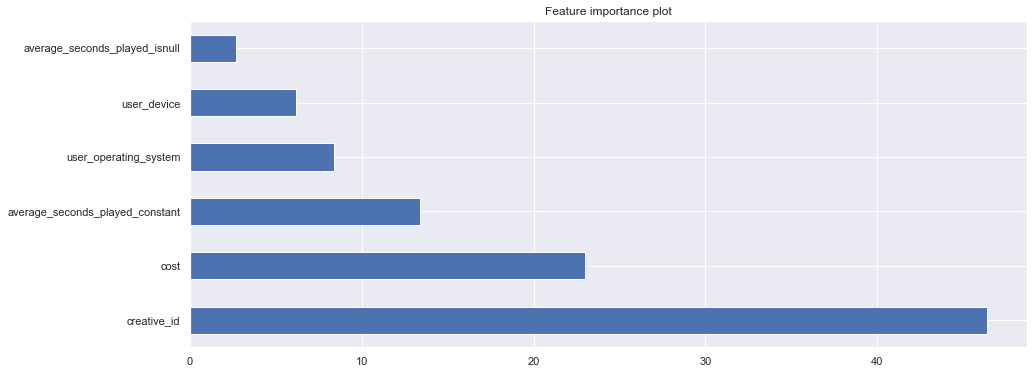

time: 436 ms


In [72]:
(pd.Series(tuned_model.feature_importances_, index=X_train.columns)
   .nlargest(9)
   .plot(kind='barh', title='Feature importance plot')) 

The creative_id is by far the most important feature, followed by the cost and then the average_seconds_played. The user_operating_system and the user_device have about the same importance. The average_seconds_played_isnull has by far the lowest importance.

## Conclusions 

> * The gradient boosting models performed well in regards to the overall metrics, whereas Random Forest had the best accuracy but performed poorly for the rest of the metrics.

> * LightGBM and Catboost were very fast compared to Random Forest.

> * The creative_id was the most important feature in all the models. On the one hand, it could be due to how we encoded the varibale. On the other hand, it makes sense that the nature of the video is very important to the revenue, since the more captivating the ad is, the more inclined the user is to watch it longer, thus surpassing the minimum number of seconds required to generate a revenue.

> * The issue with relying heavily on the creative_id to make a decison , is when we are confronted with unseen videos.

> * It would be interesting to add more features and rows to the dataset in order to improve the performance, especially since we have imbalanced data.

> * We can also experiment with Neural Network Embeddings that deal well with categorical features that have high-cardinality like creative_id.

> * Selecting the right metric for these sorts of problems is very important, and it mainly depends on the business need the model is trying to fulfil.